# Improved balance data


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import data
from dataset import rdDataset_old
from dataset import H5Dataset
from model import conv2d_lstm
from math import log10

import sys
log_path = 'log_prePhiBin_tipsTheta_5k_2c.txt'
sys.stdout = open(log_path, "w")

# CUDA for PyTorch
torch.cuda.is_available()
torch.cuda.empty_cache()

# clean up
import gc
gc.collect()

# check GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('Using device:'+str(device))

In [2]:
# Parameters
params = {'test_split': .25,
          'shuffle_dataset': True,
          'batchsize': 35,
          'testBatchsize': 35,
          'random_seed': 42,
          'numworkers':24,
          'pinmemory':True}
max_epoches = 100
learning_rate = 1e-5
drop_rate = 0.0

print('===> Loading datasets')
dataset = H5Dataset('./reformattedData_20220523/CNN_200x200_per100_prePhi_tipsTheta_2channels_compressed.hdf5')

# Creating data indices for training and validation splits:
training_data_loader, testing_data_loader = data.DatasetSplit(dataset, **params)

print('===> Building model')
model = conv2d_lstm(drop_rate).to(device)
# criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)
        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    return epoch, epoch_loss / len(training_data_loader)
    
def test():
    avg_error = 0
    avg_loss = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)
            prediction = model(input)
            tmp_error = 0
            for j in range(len(prediction)):
                tmp_error += torch.sqrt(torch.mean((prediction[j]-target[j])**2))/torch.max(target[j])
            avg_error += tmp_error / len(prediction)
            mse = criterion(prediction, target)
            avg_loss += mse
    print("===> Avg. Loss: {:.4f} ".format(avg_loss / len(testing_data_loader)))
    print("===> Avg. Error: {:.4f} ".format(avg_error / len(testing_data_loader)))
    return avg_loss / len(testing_data_loader),avg_error / len(testing_data_loader)

def checkpoint(epoch):
    model_out_path = "./checkpoint_NGCNN_conv_lstm/model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [3]:
load = False

if load==True:
    model = torch.load("./checkpoint_NGCNN_conv_lstm/model_epoch_52.pth")
else:
    L_train_loss = []
    L_test_loss = []
    L_test_error = []

    for epoch in range(1, max_epoches + 1):
        train_loss = train(epoch)
        test_loss,test_error = test()
        checkpoint(epoch)

        L_train_loss.append(train_loss)
        L_test_loss.append(test_loss)
        L_test_error.append(test_error)

KeyboardInterrupt: 

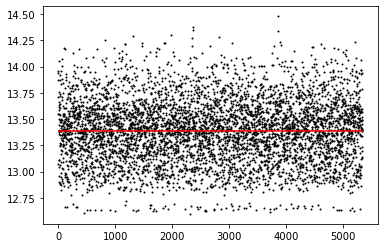

In [4]:
import data
import importlib 
importlib.reload(data)

data.TestErrorPlot(model,device, testing_data_loader)

In [5]:
from matplotlib import pyplot as plt
prediction_L = []
input_L = []
target_L = []
i=0

# h5 = h5py.File('./reformattedData/CNN_all_cases_200x200_per100_previousPhi_withTipsTheta_2layers_compressed.hdf5', mode='r')
# theta = h5.get('theta')

with torch.no_grad():
    for batch in testing_data_loader:
        if i==1:
            break
        input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)
        input_L.append(input)
        target_L.append(target)
        prediction = model(input)
        prediction_L.append(prediction)
        i = i+1

/tmp/ipykernel_515576/3811708523.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,13), dpi=100)


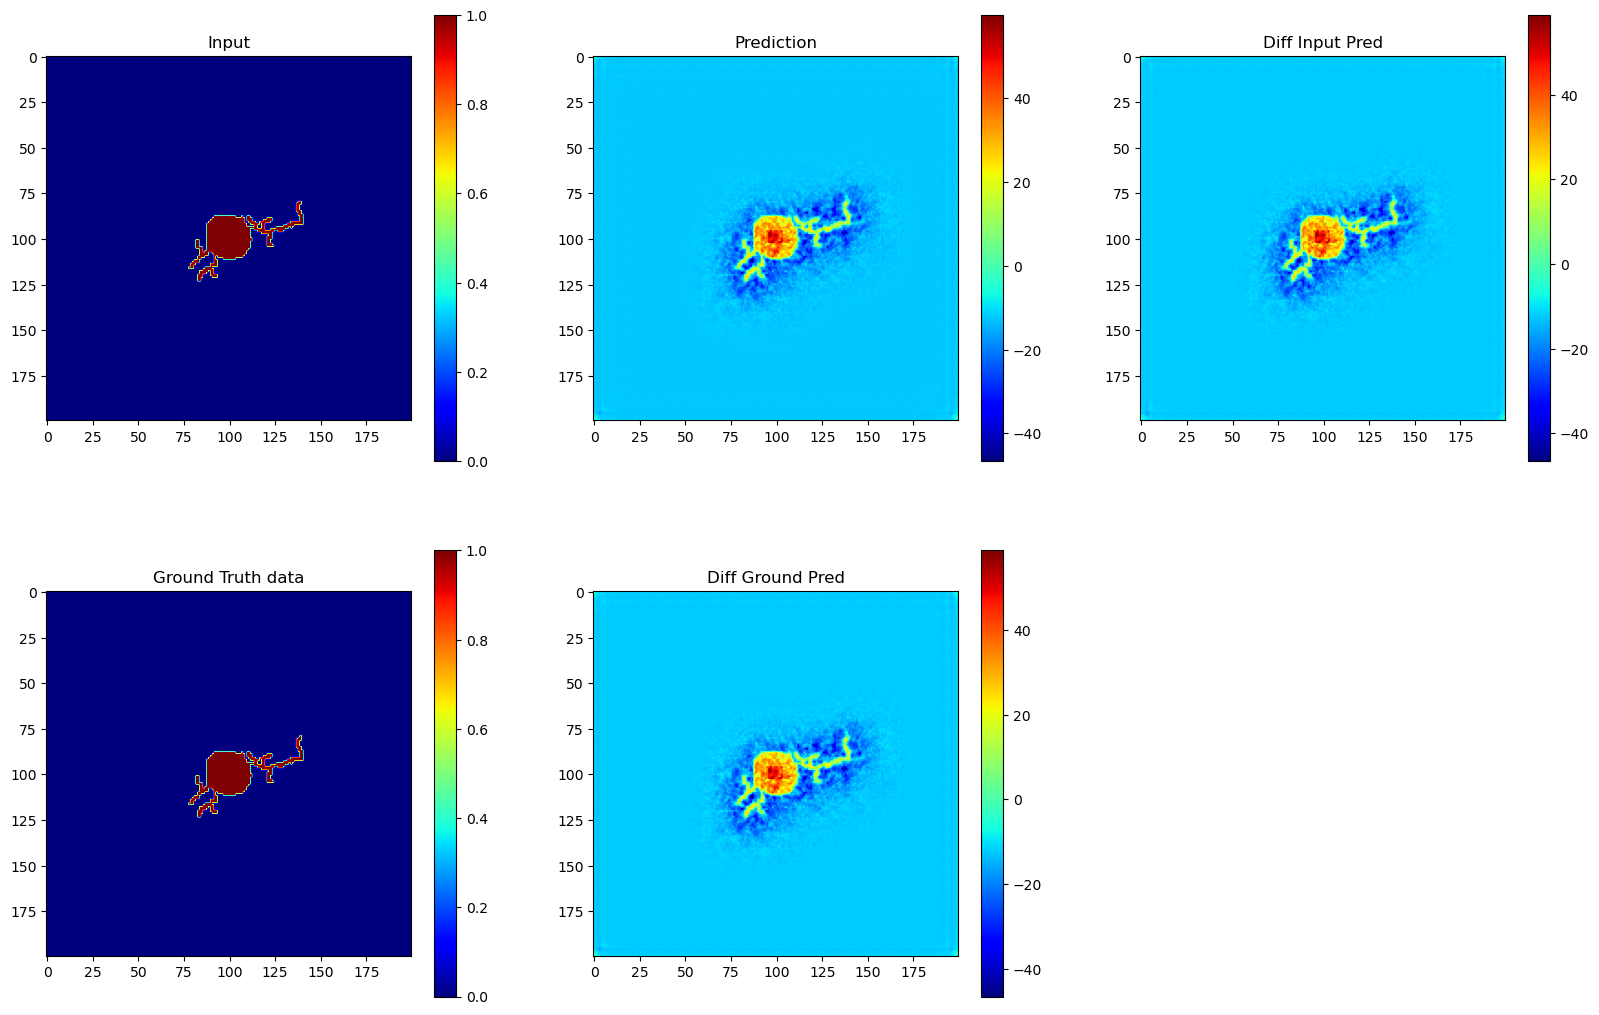

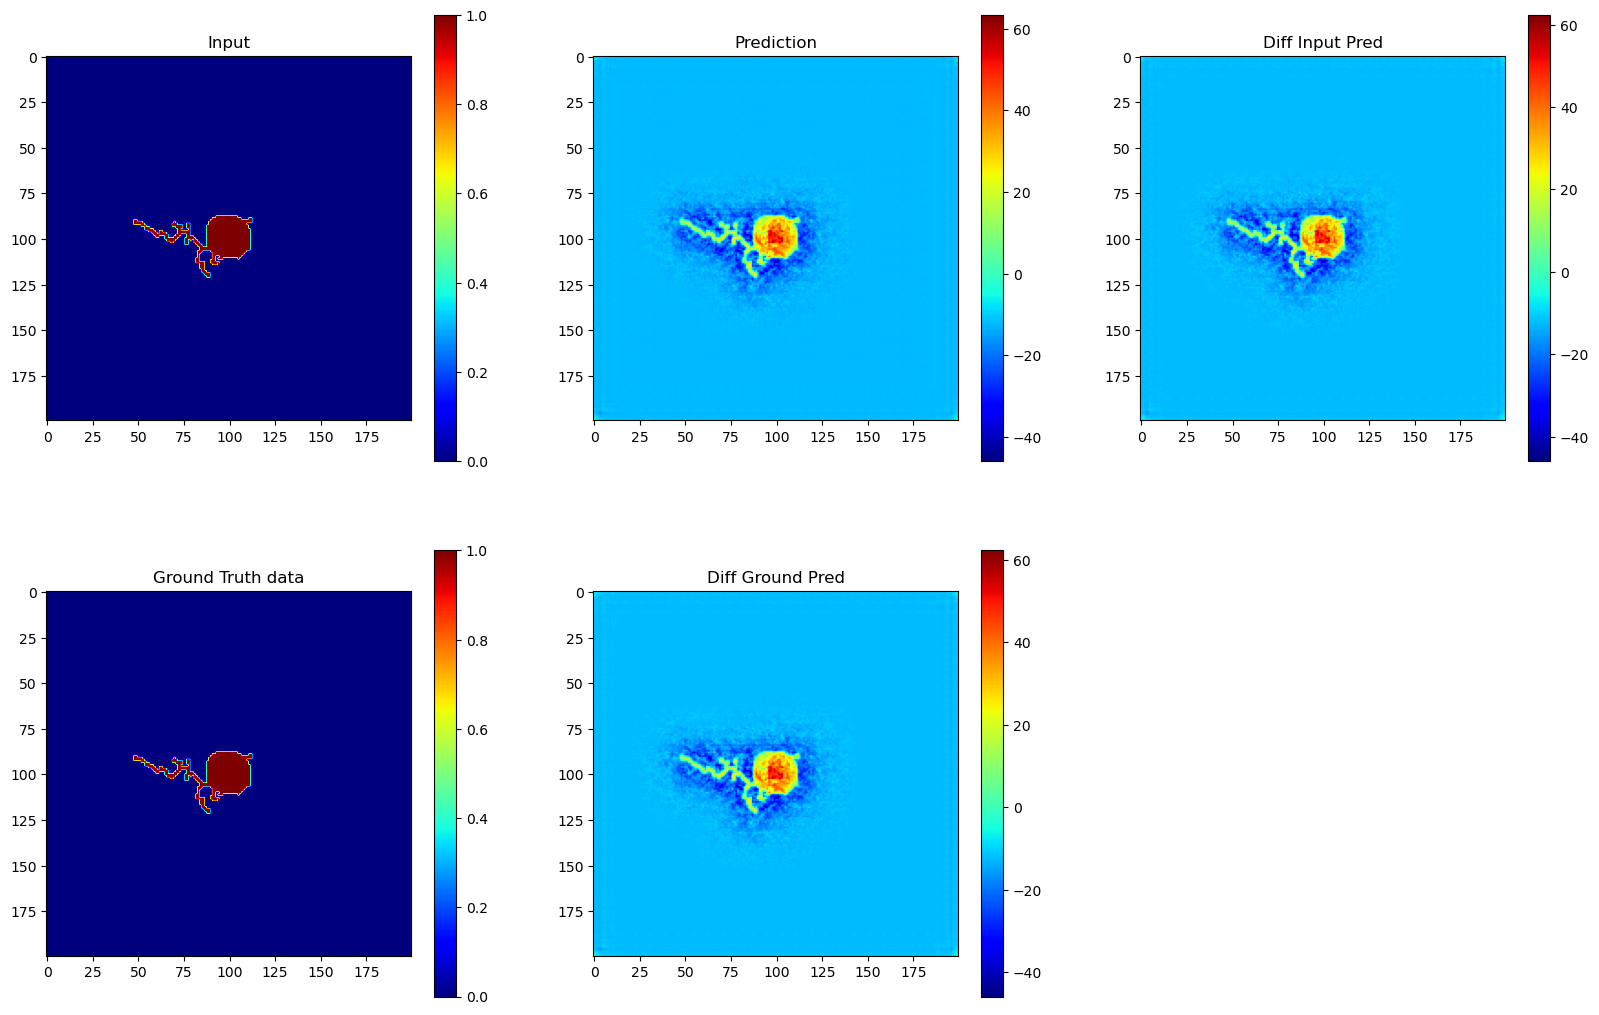

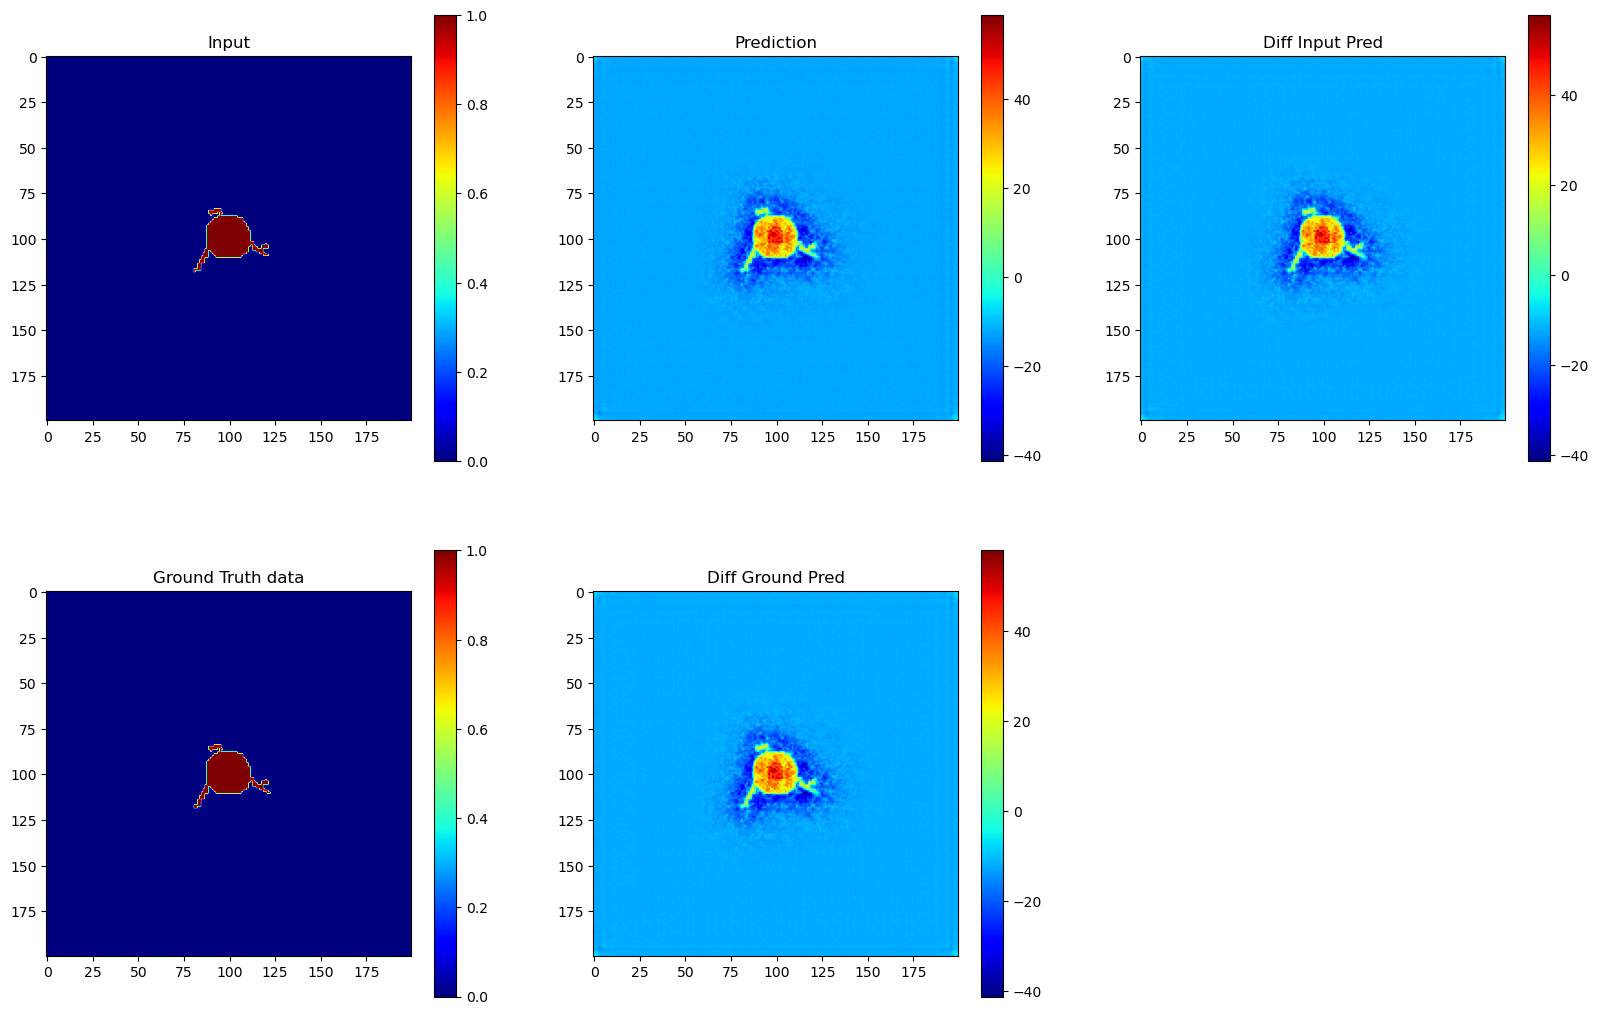

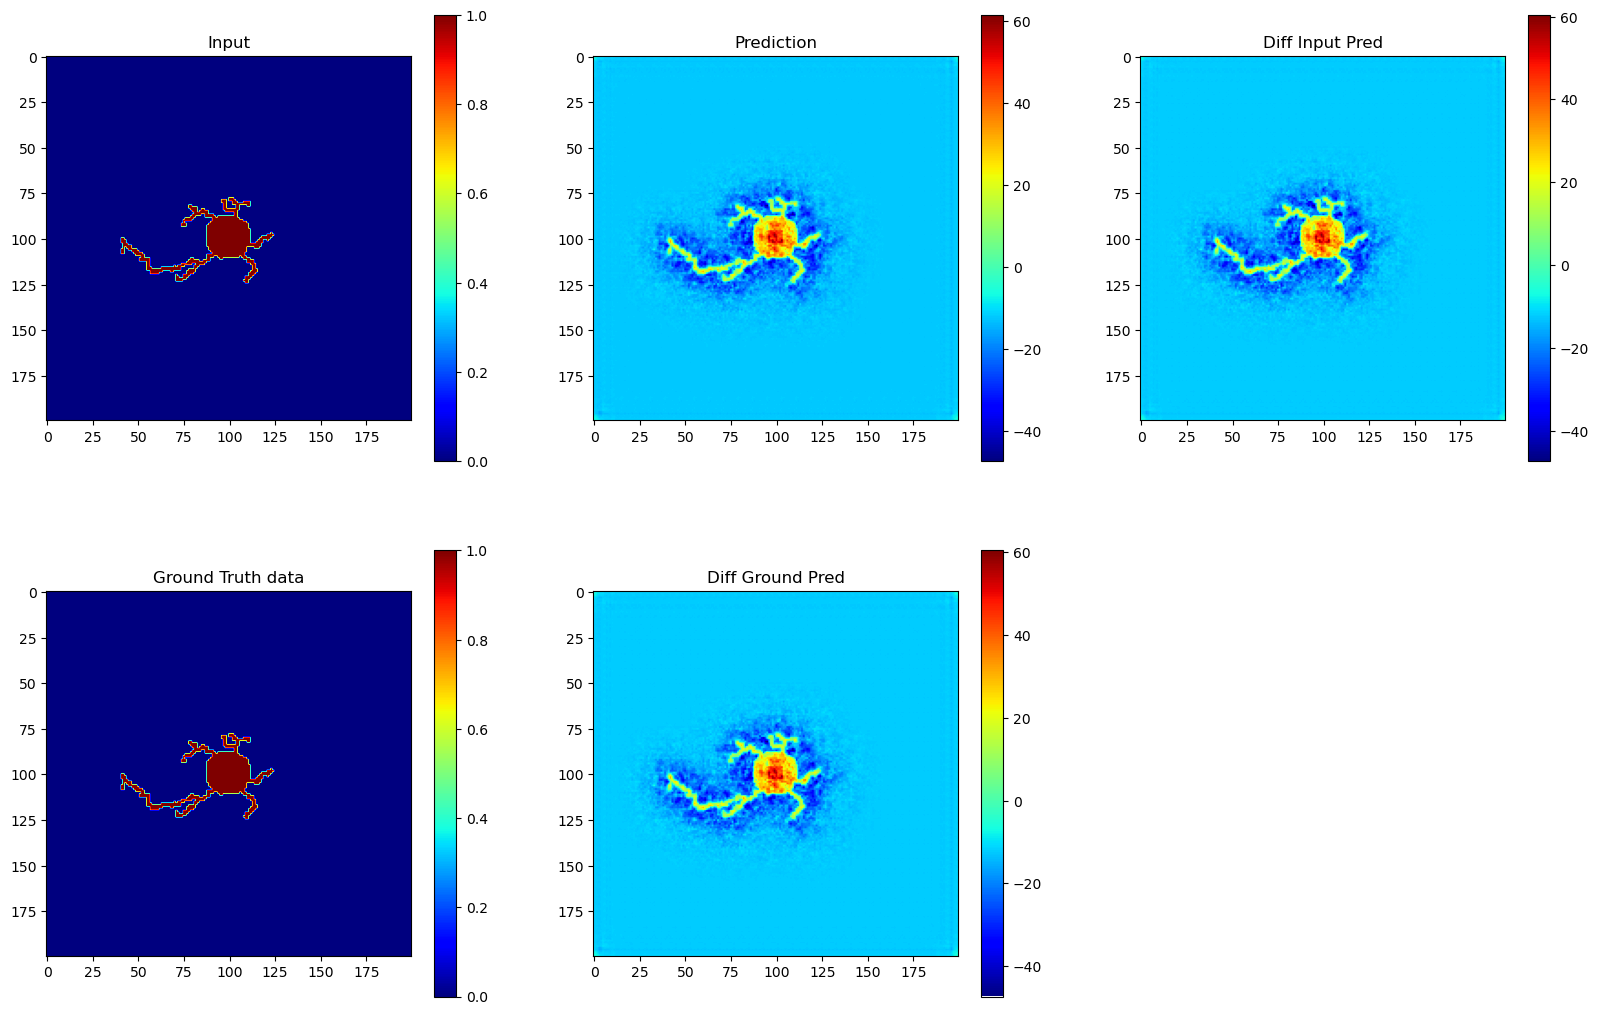

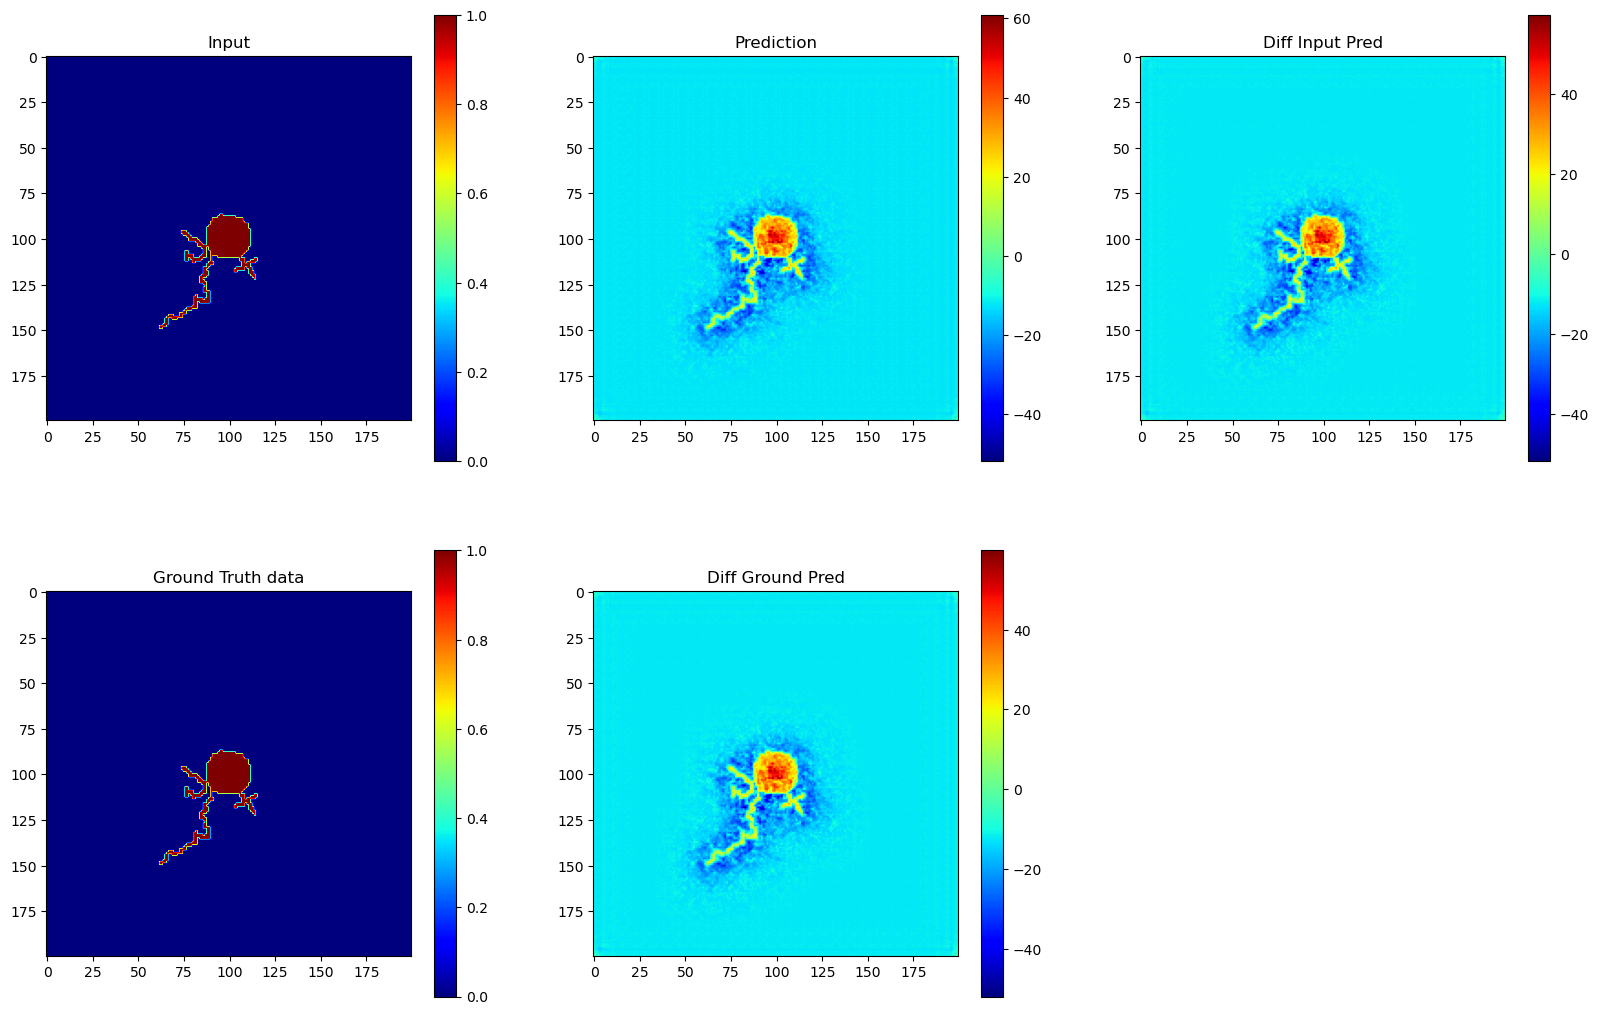

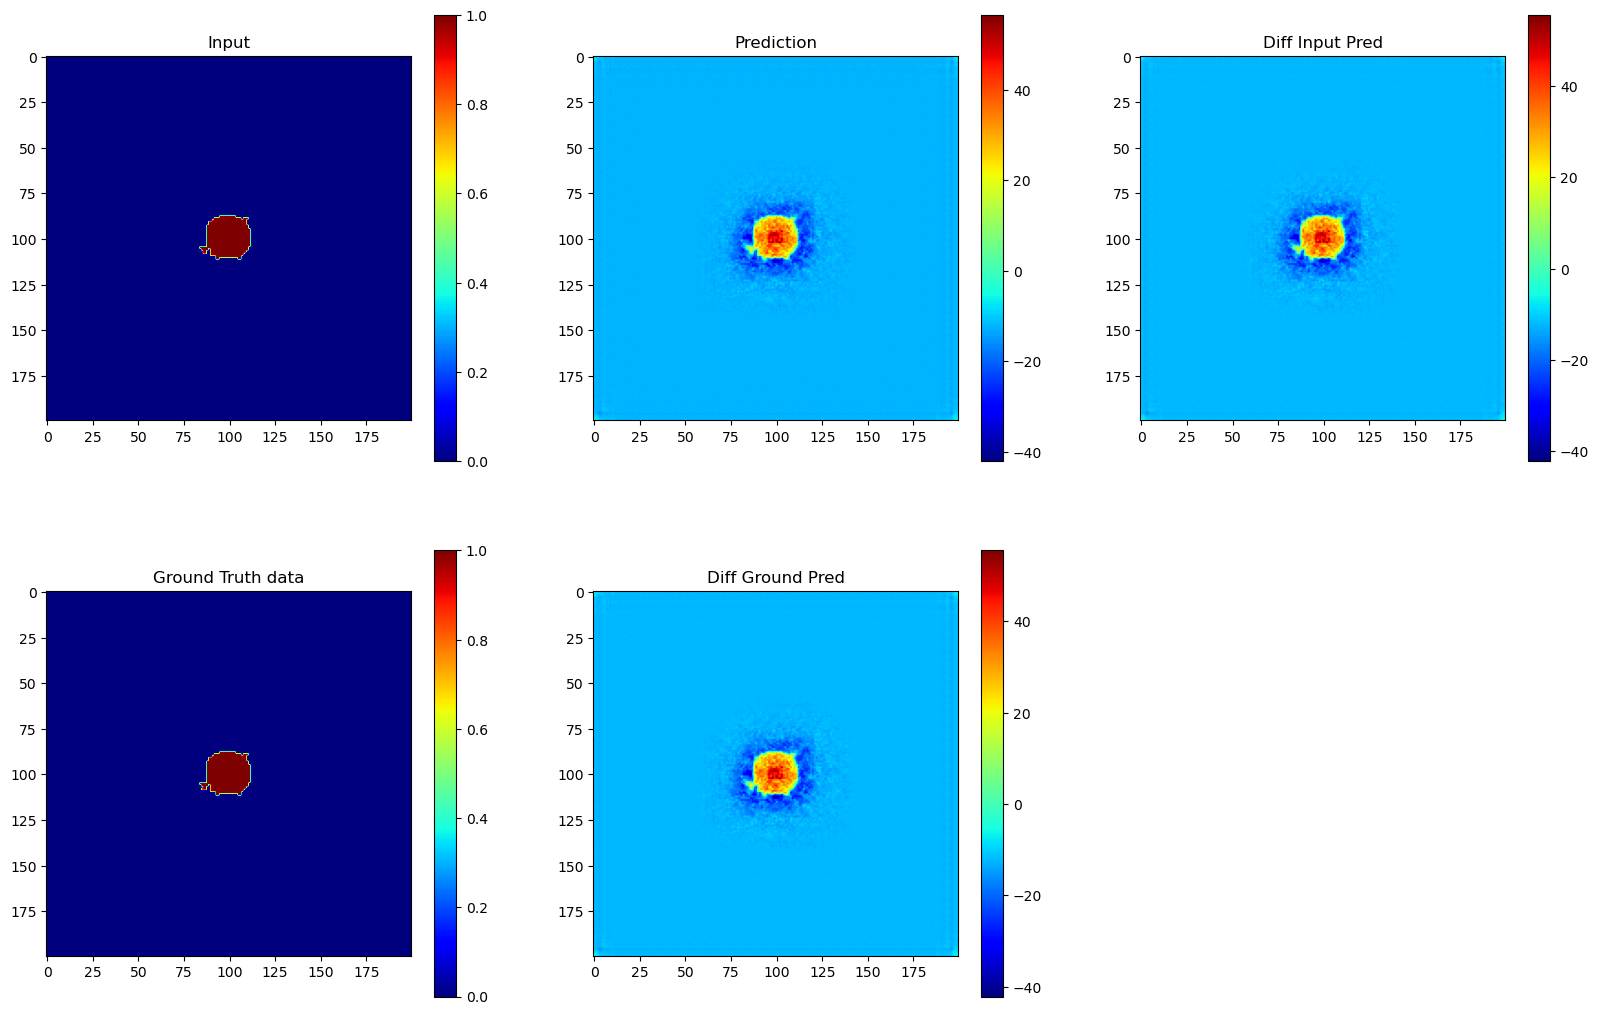

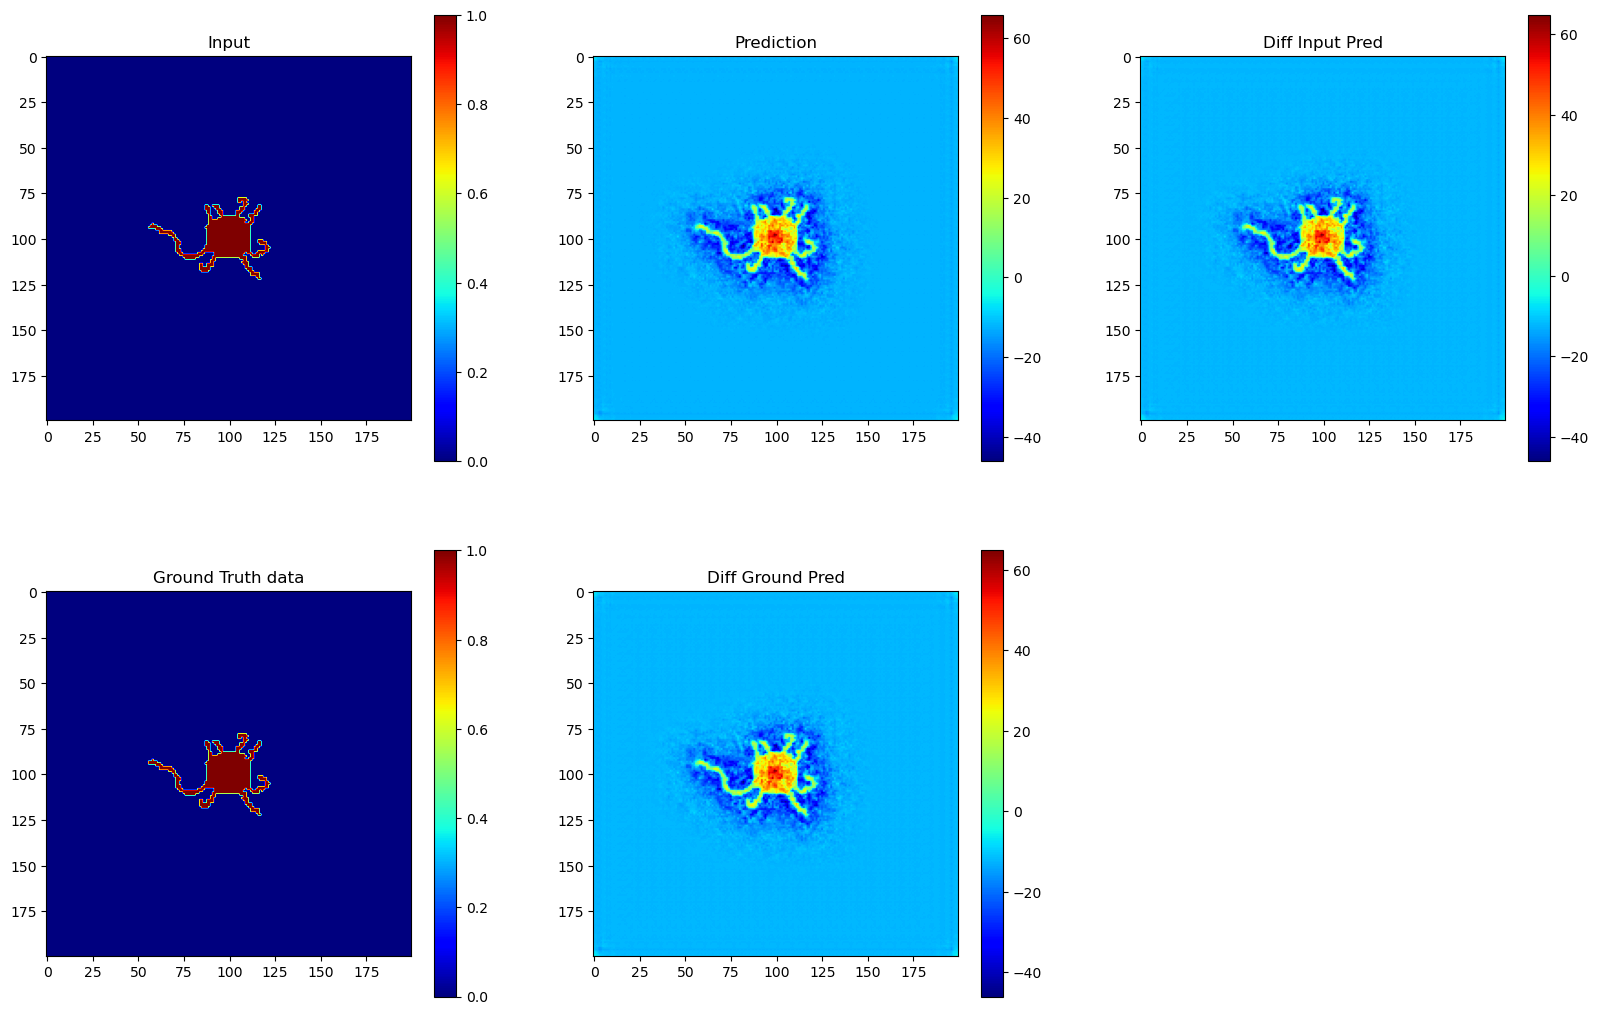

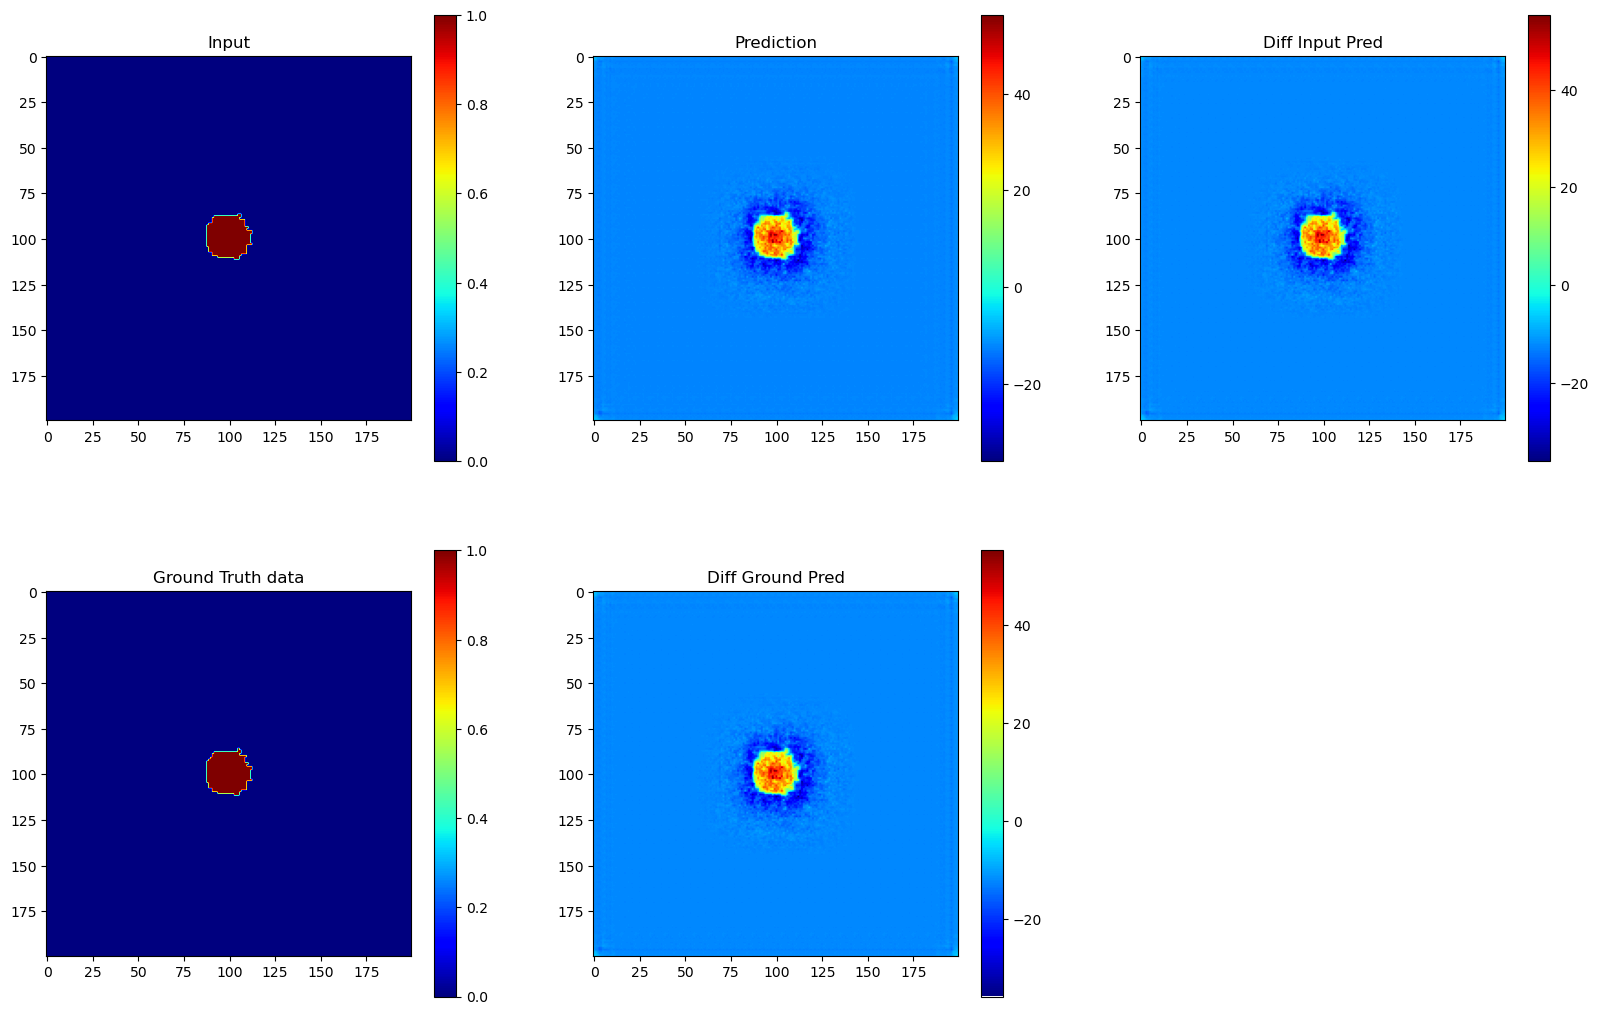

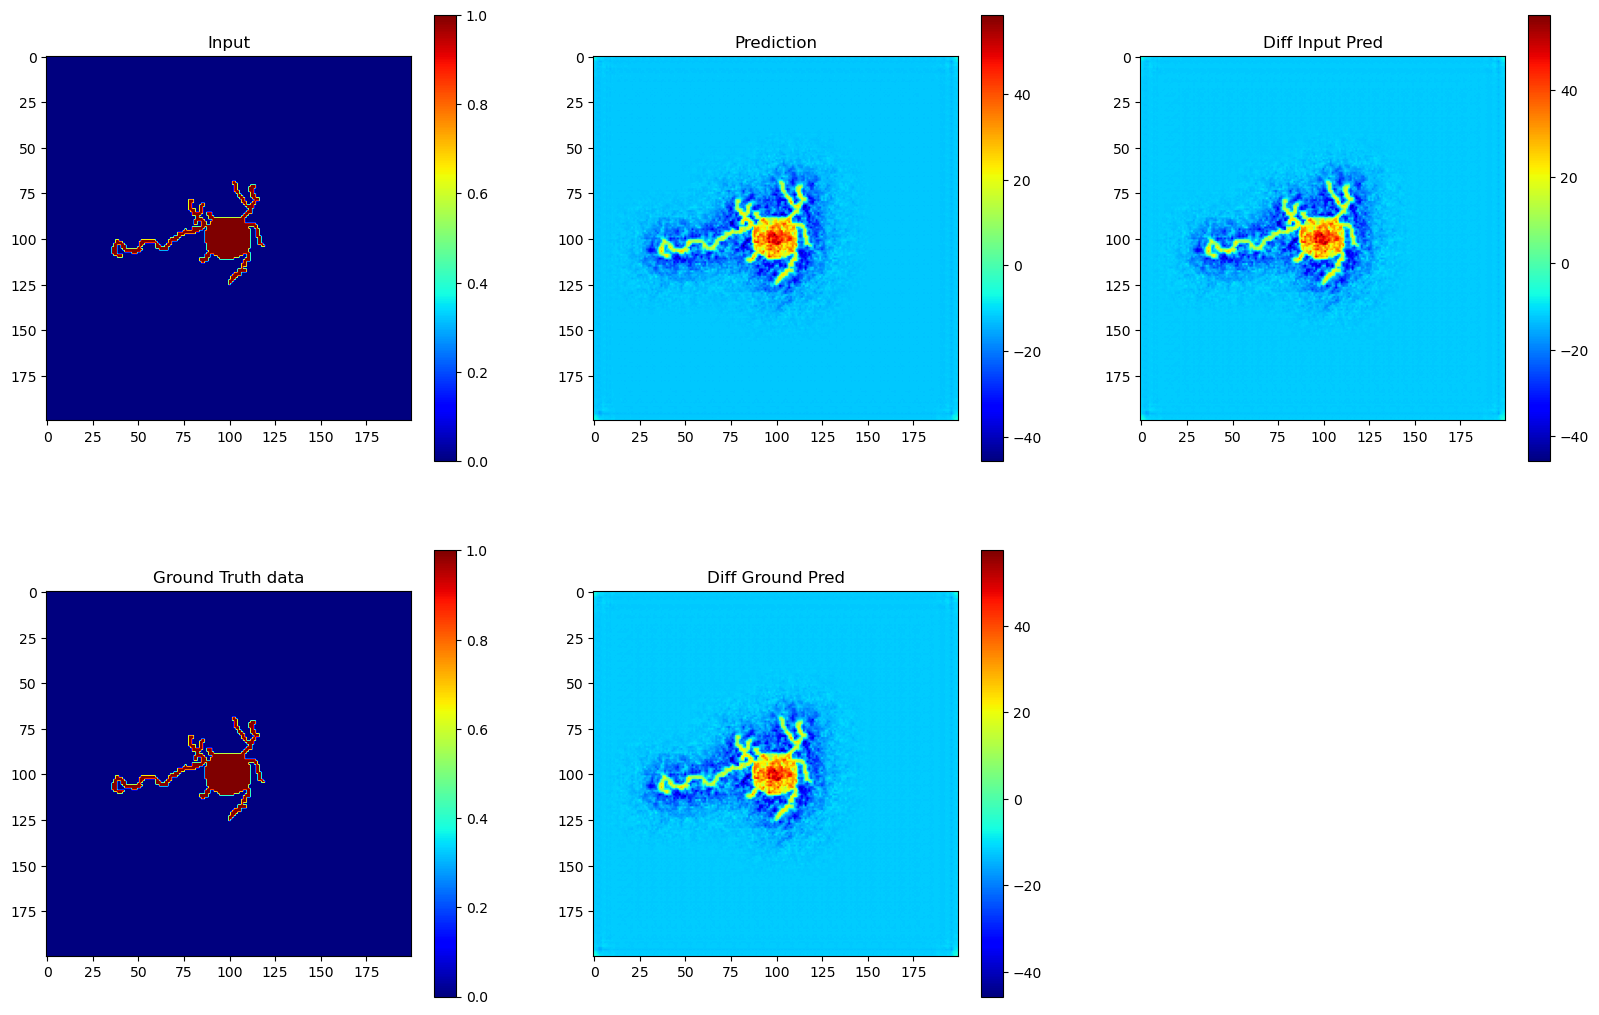

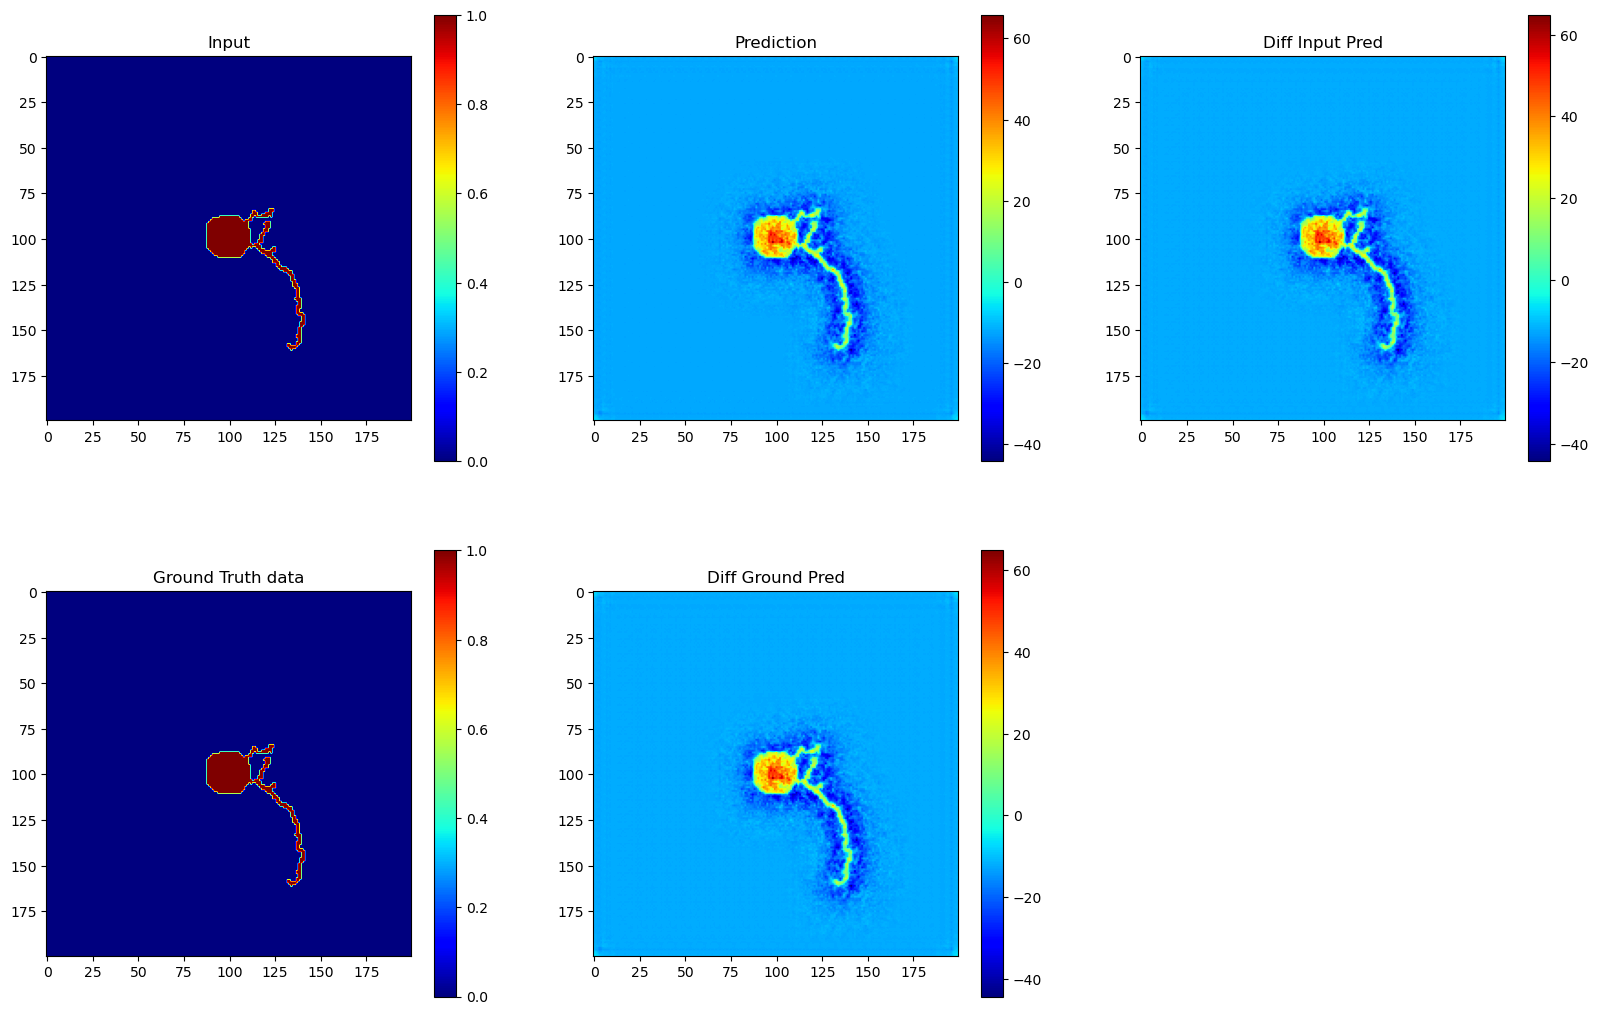

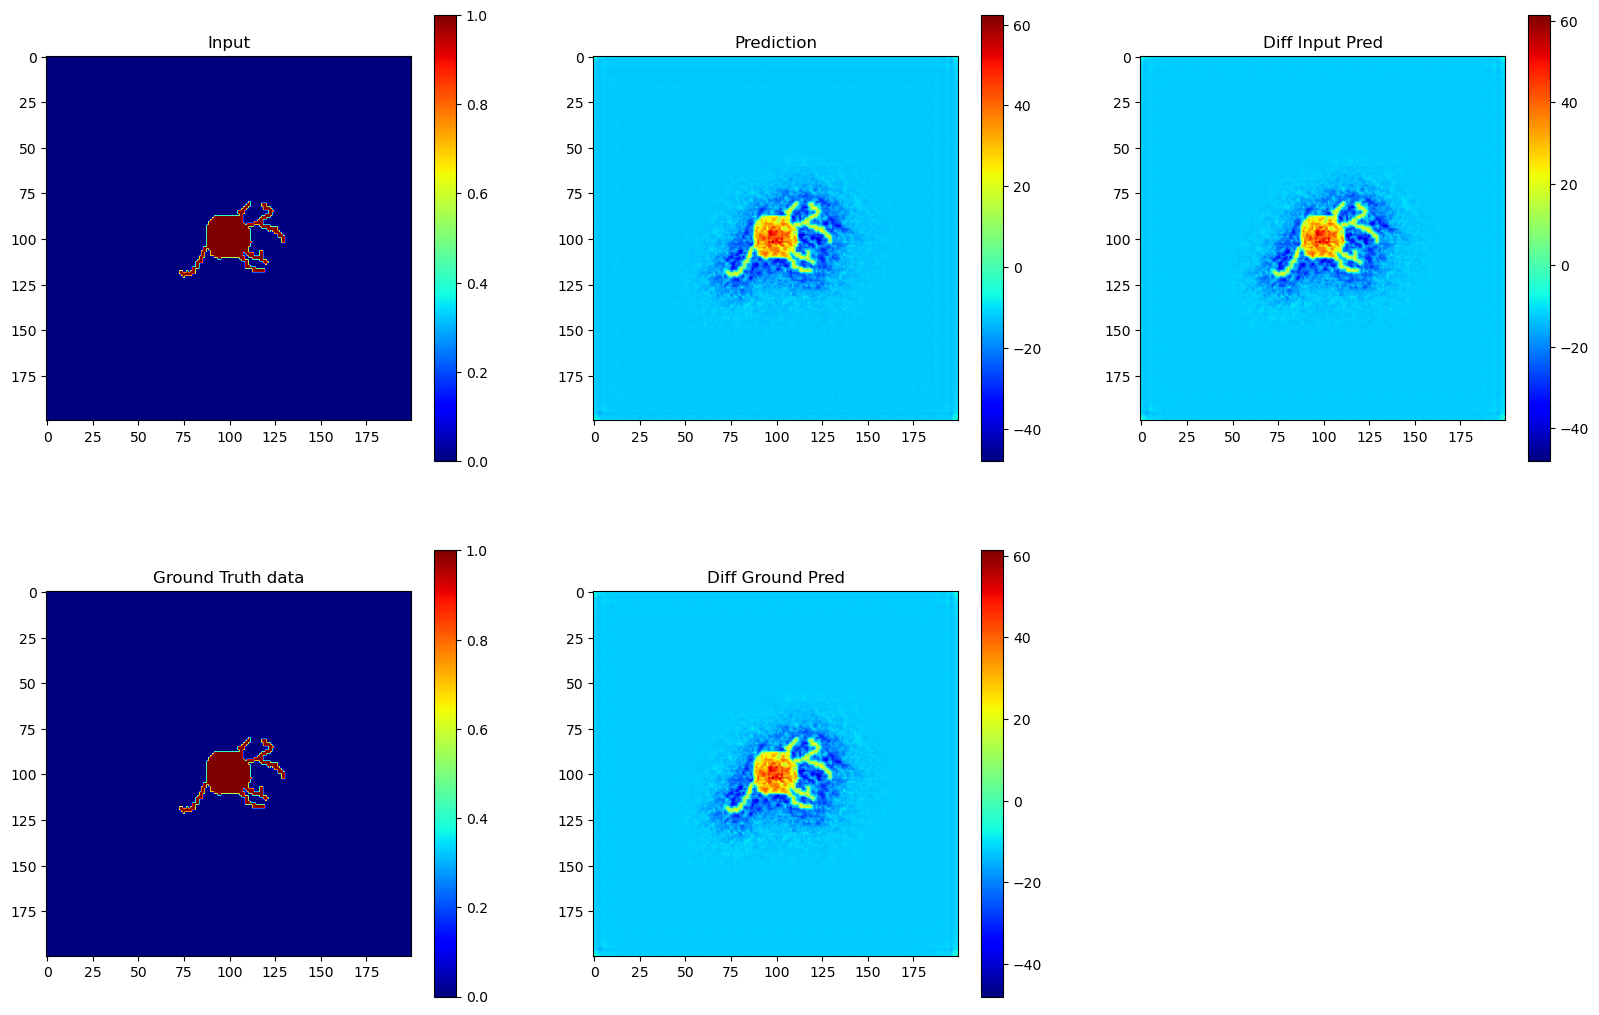

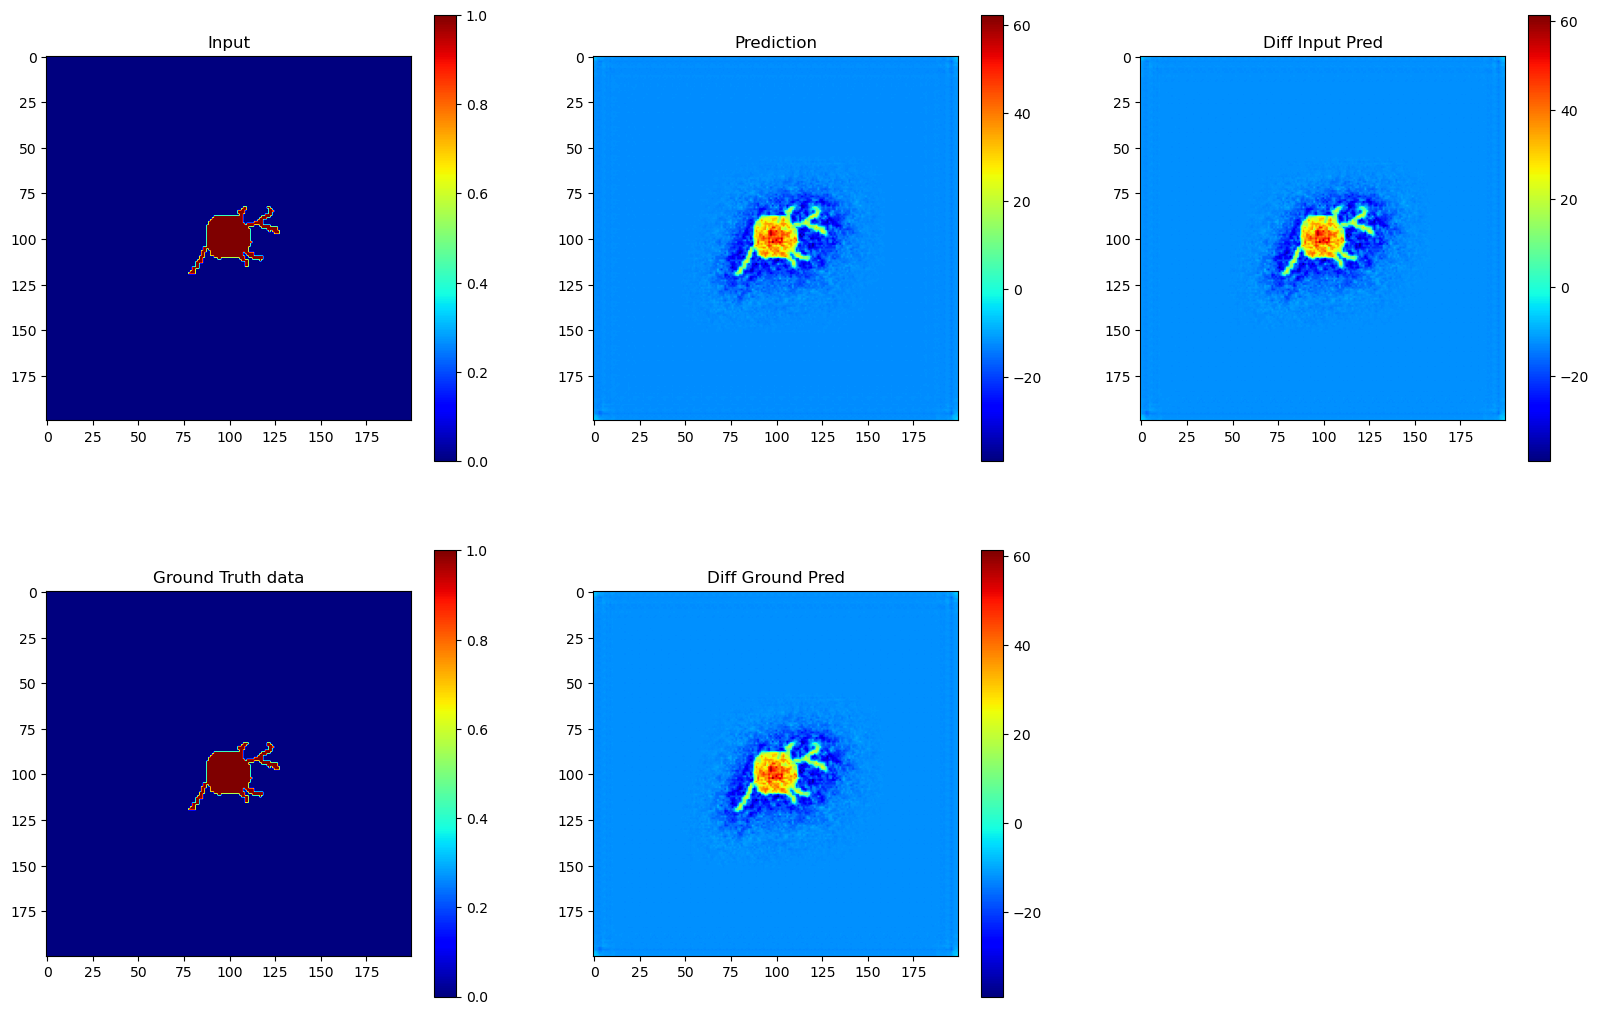

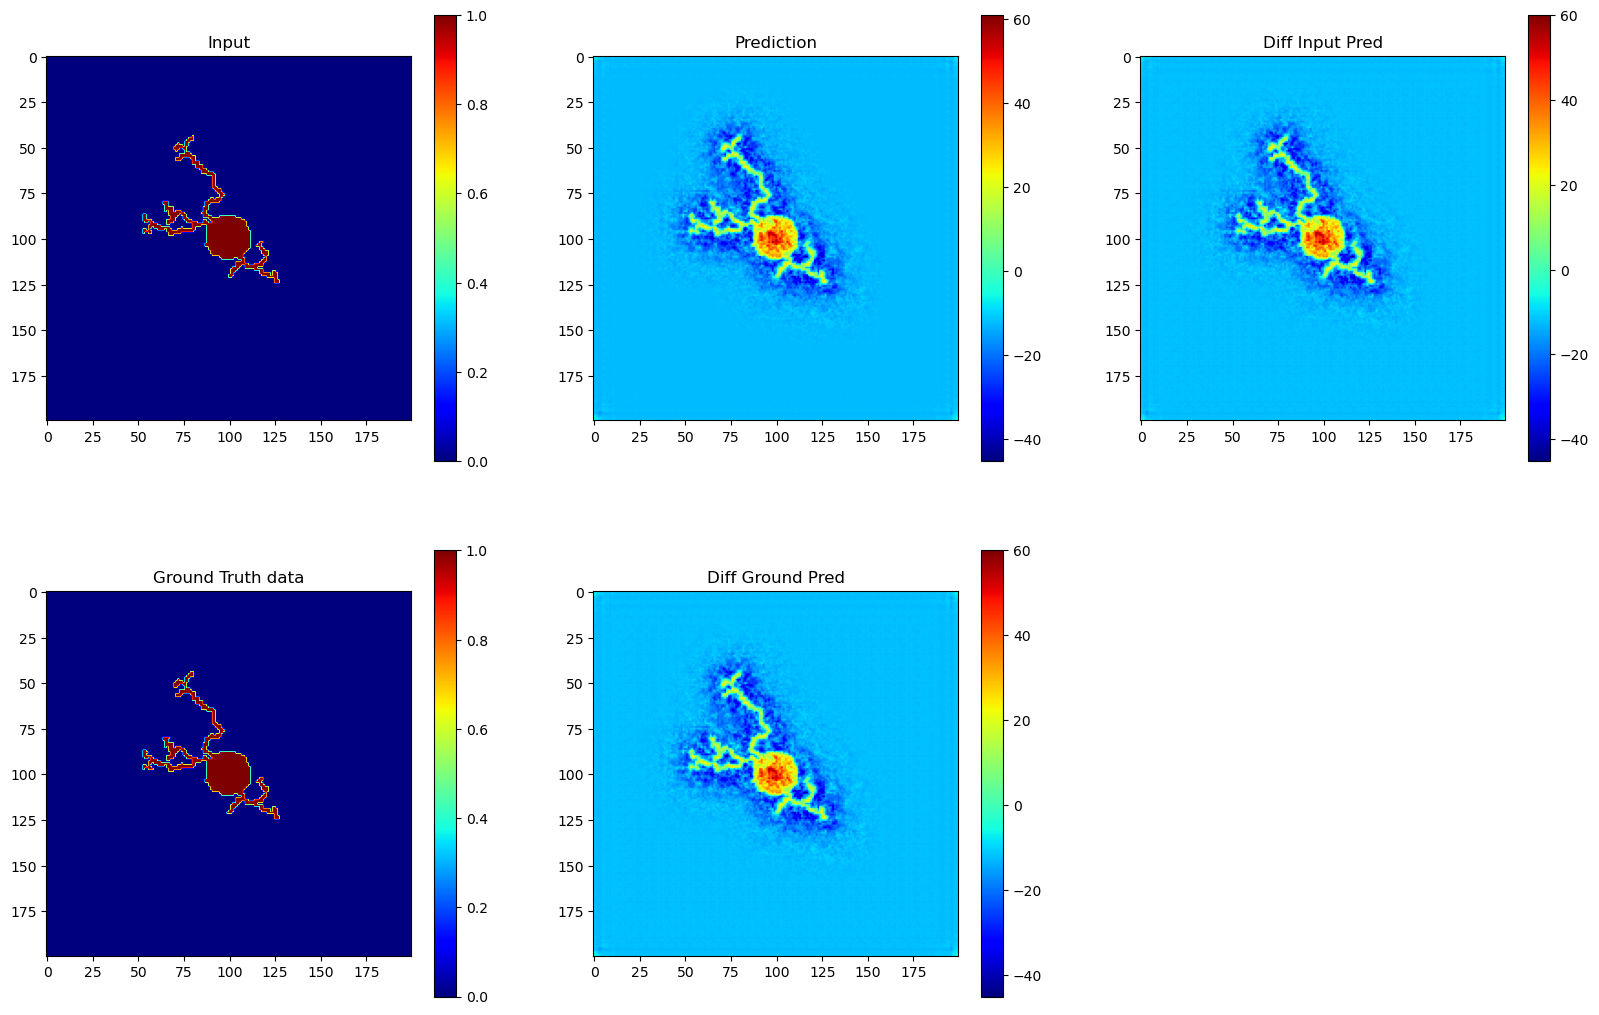

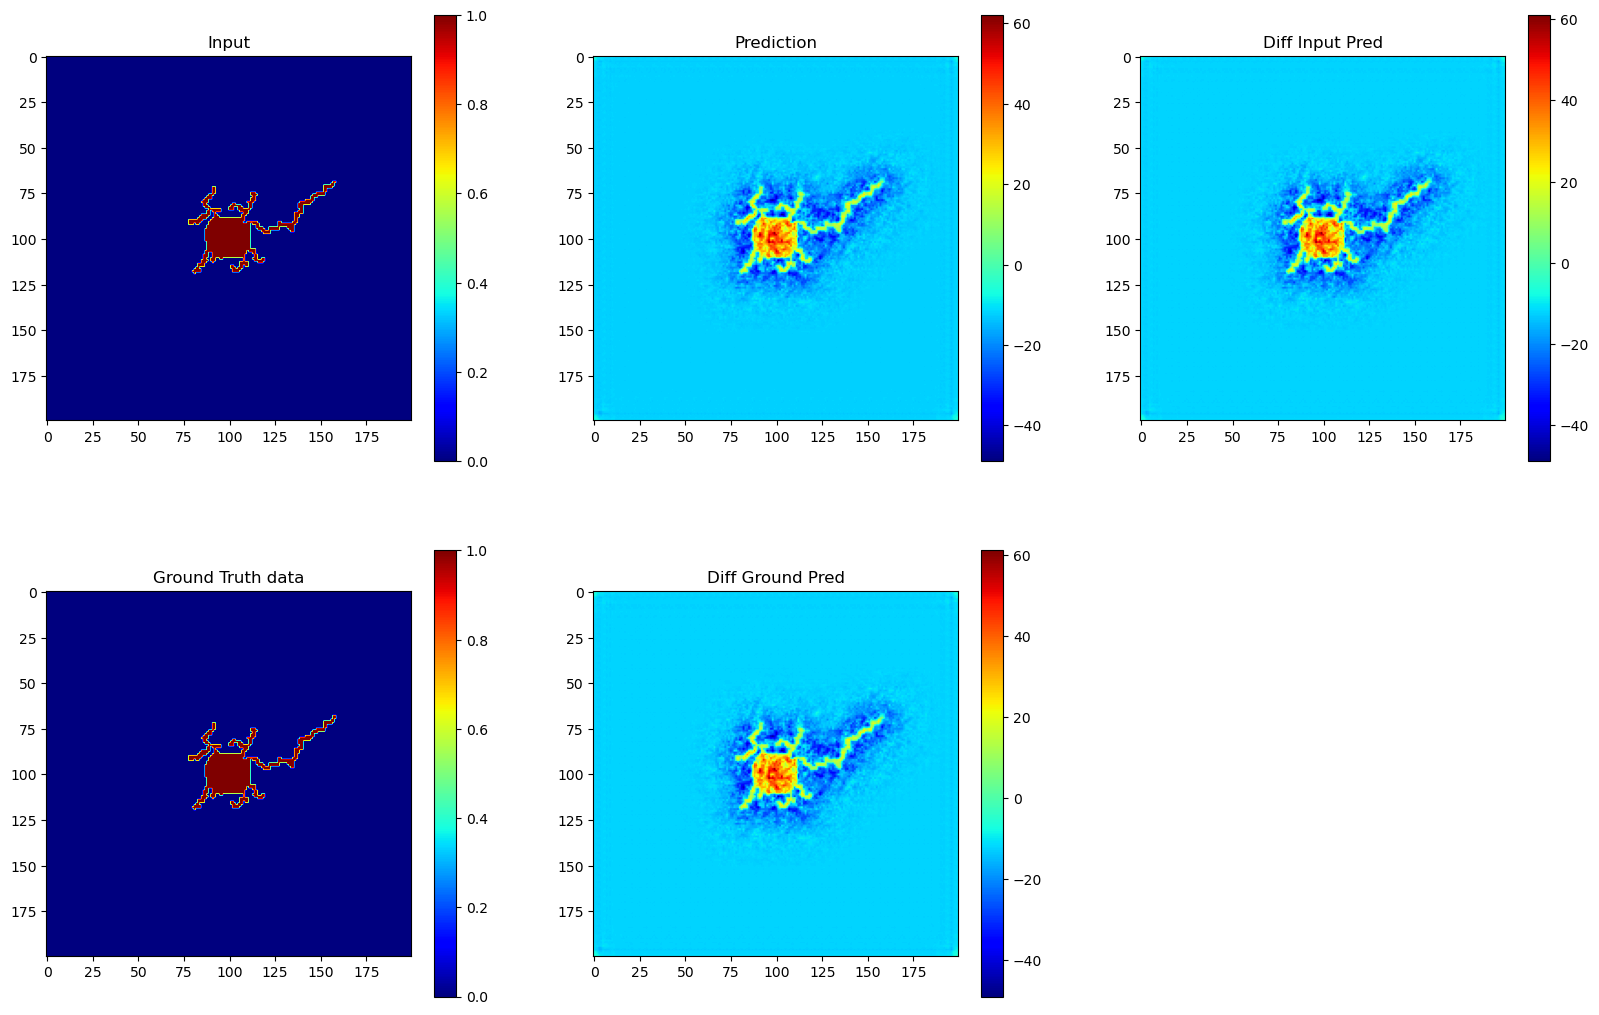

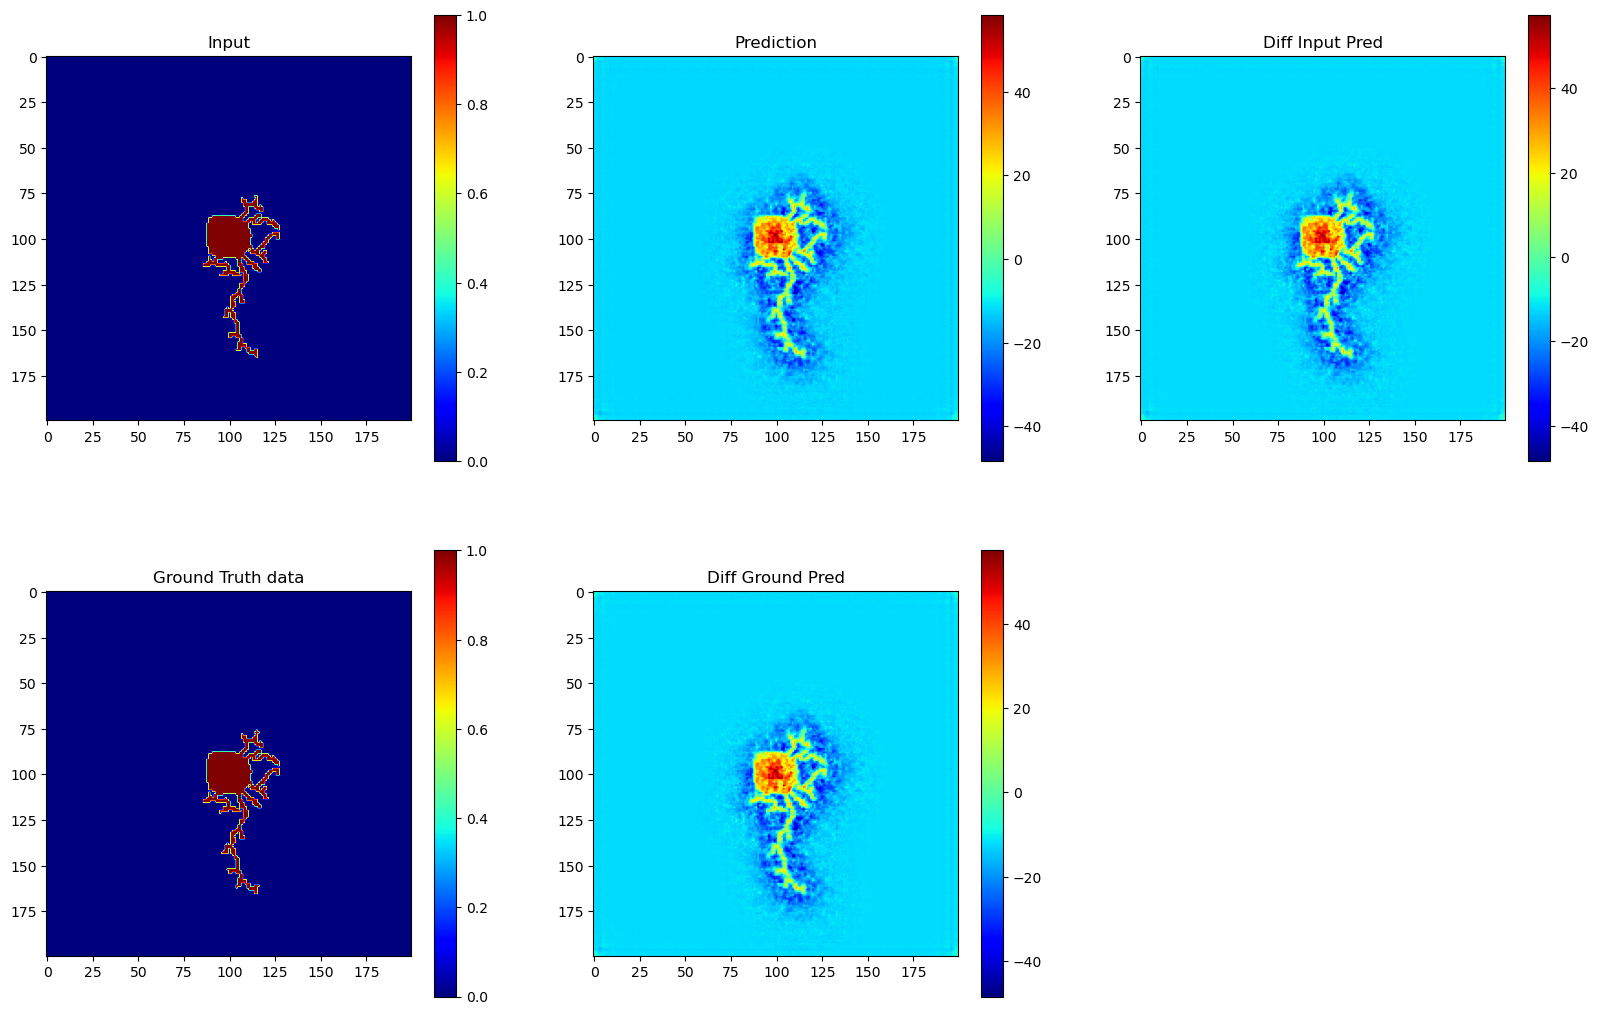

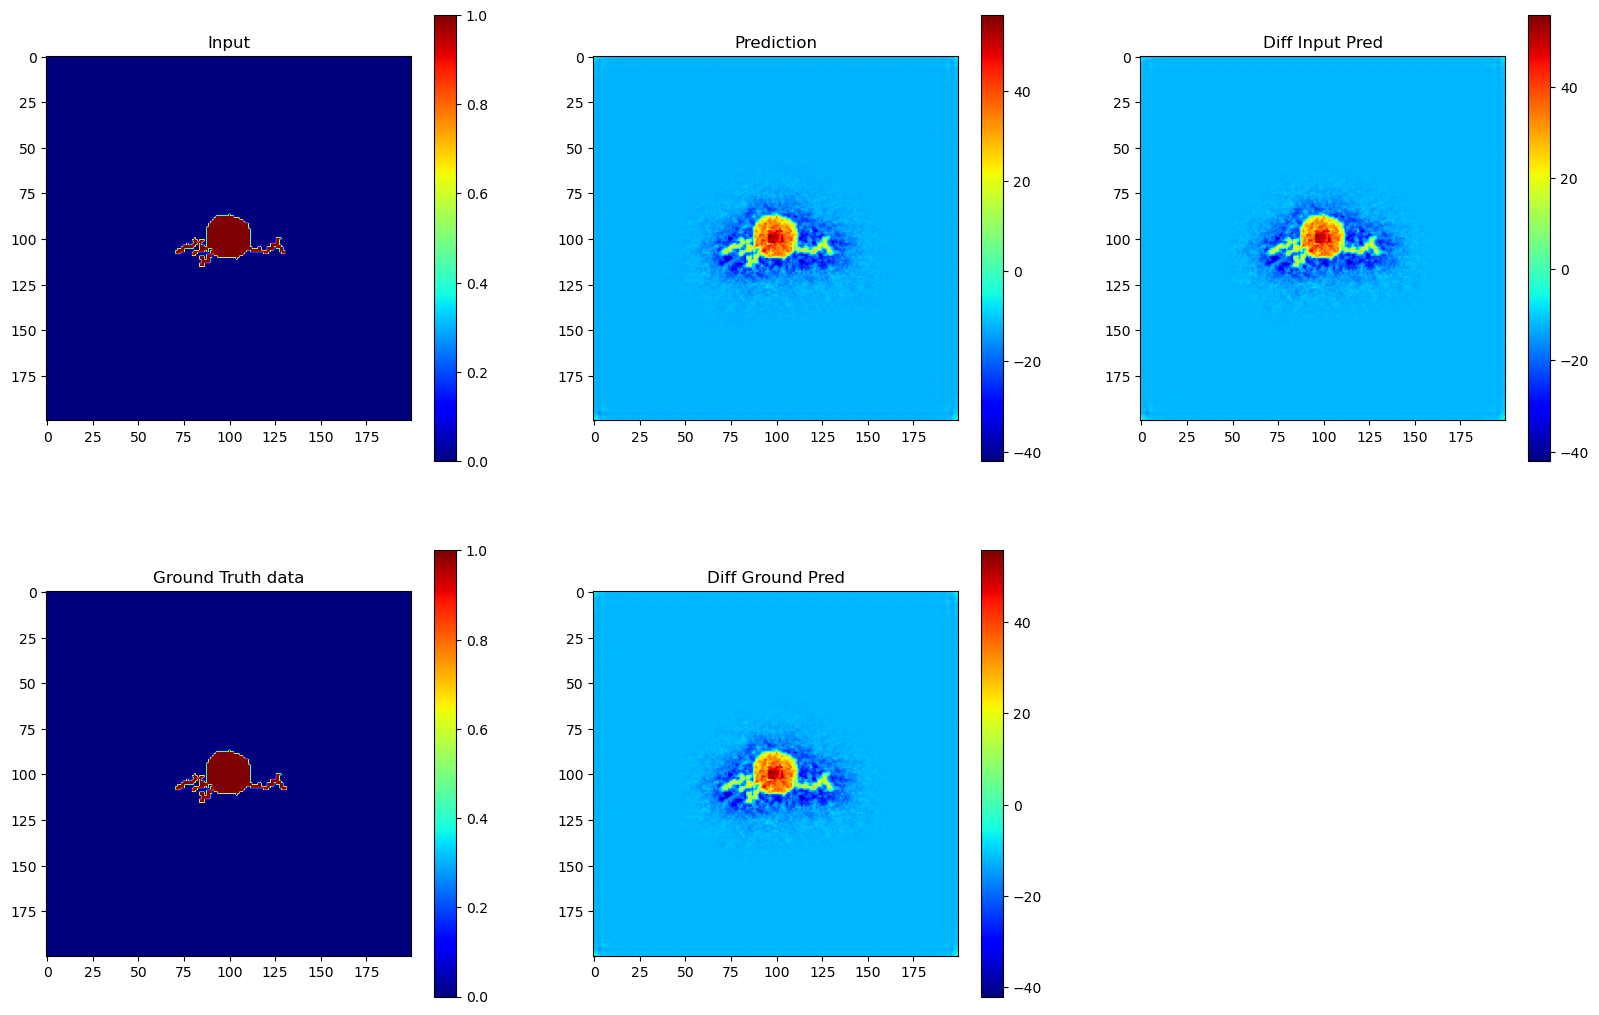

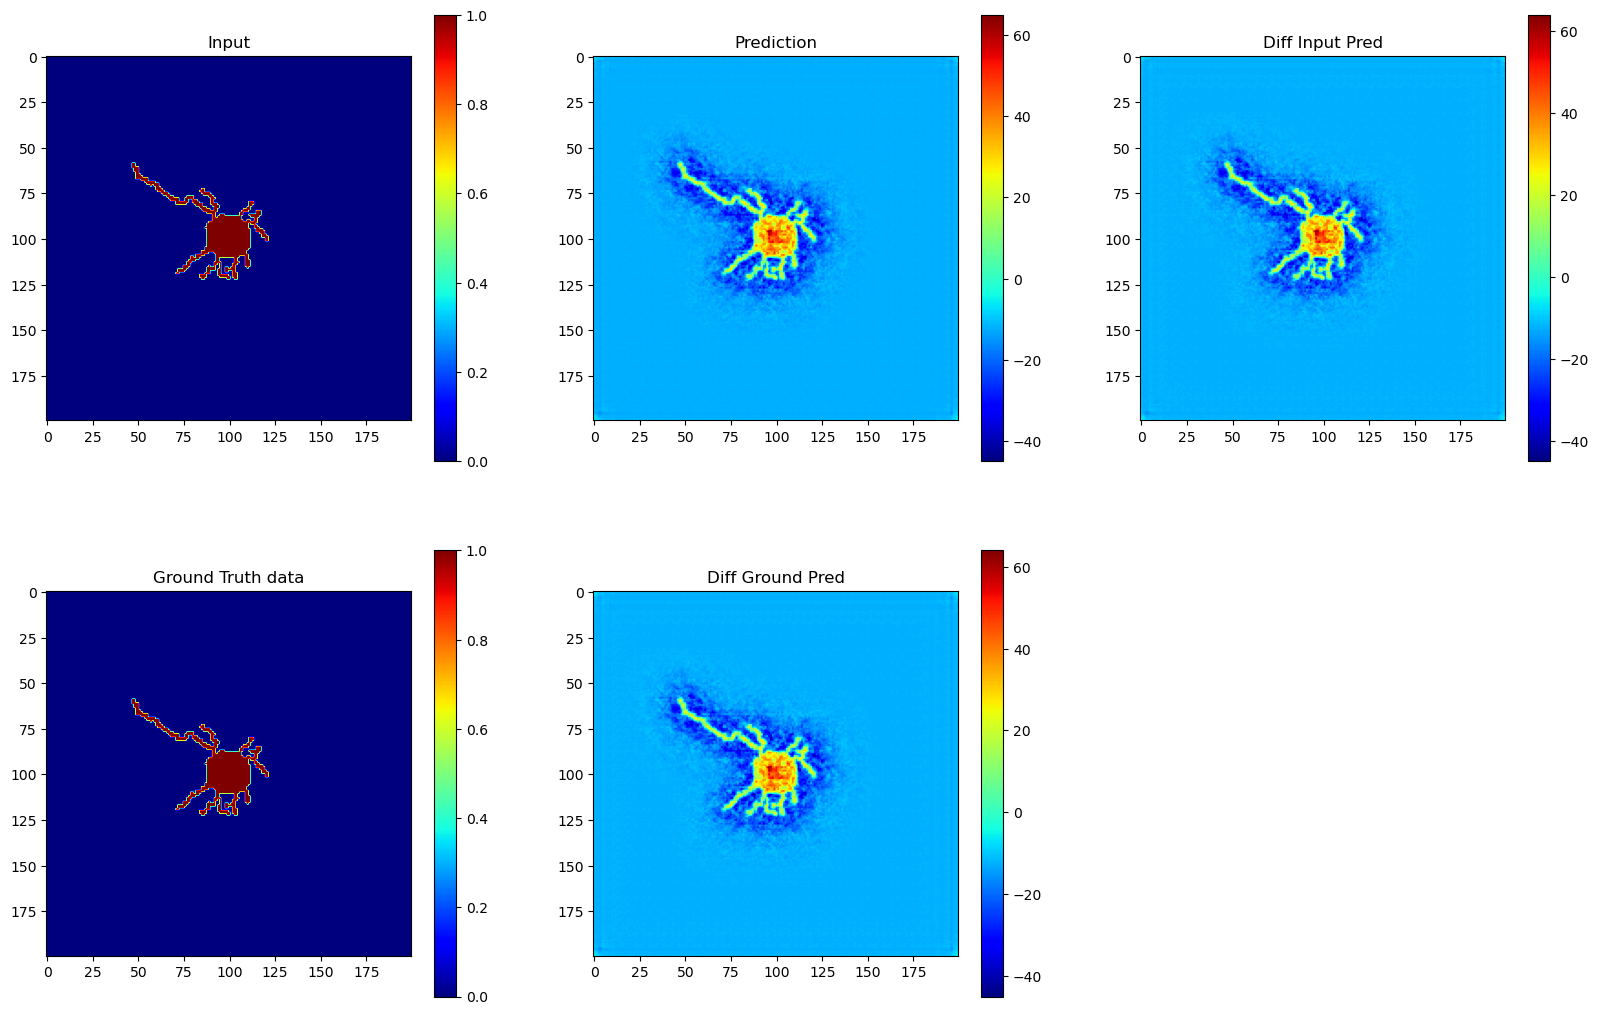

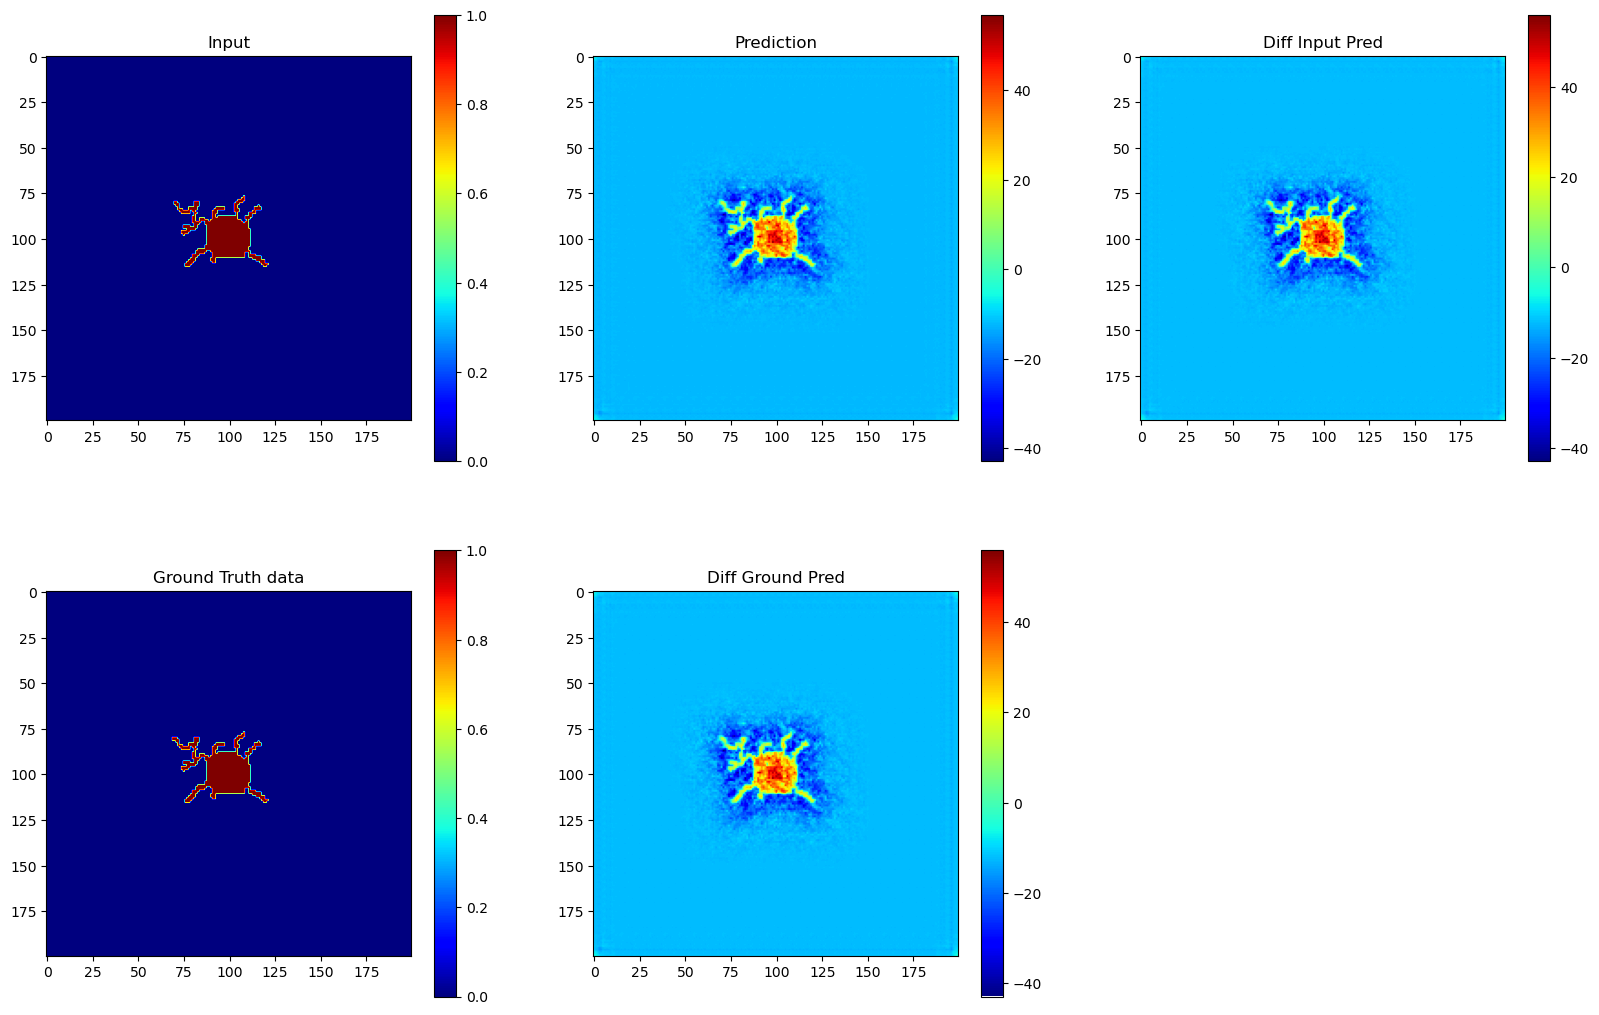

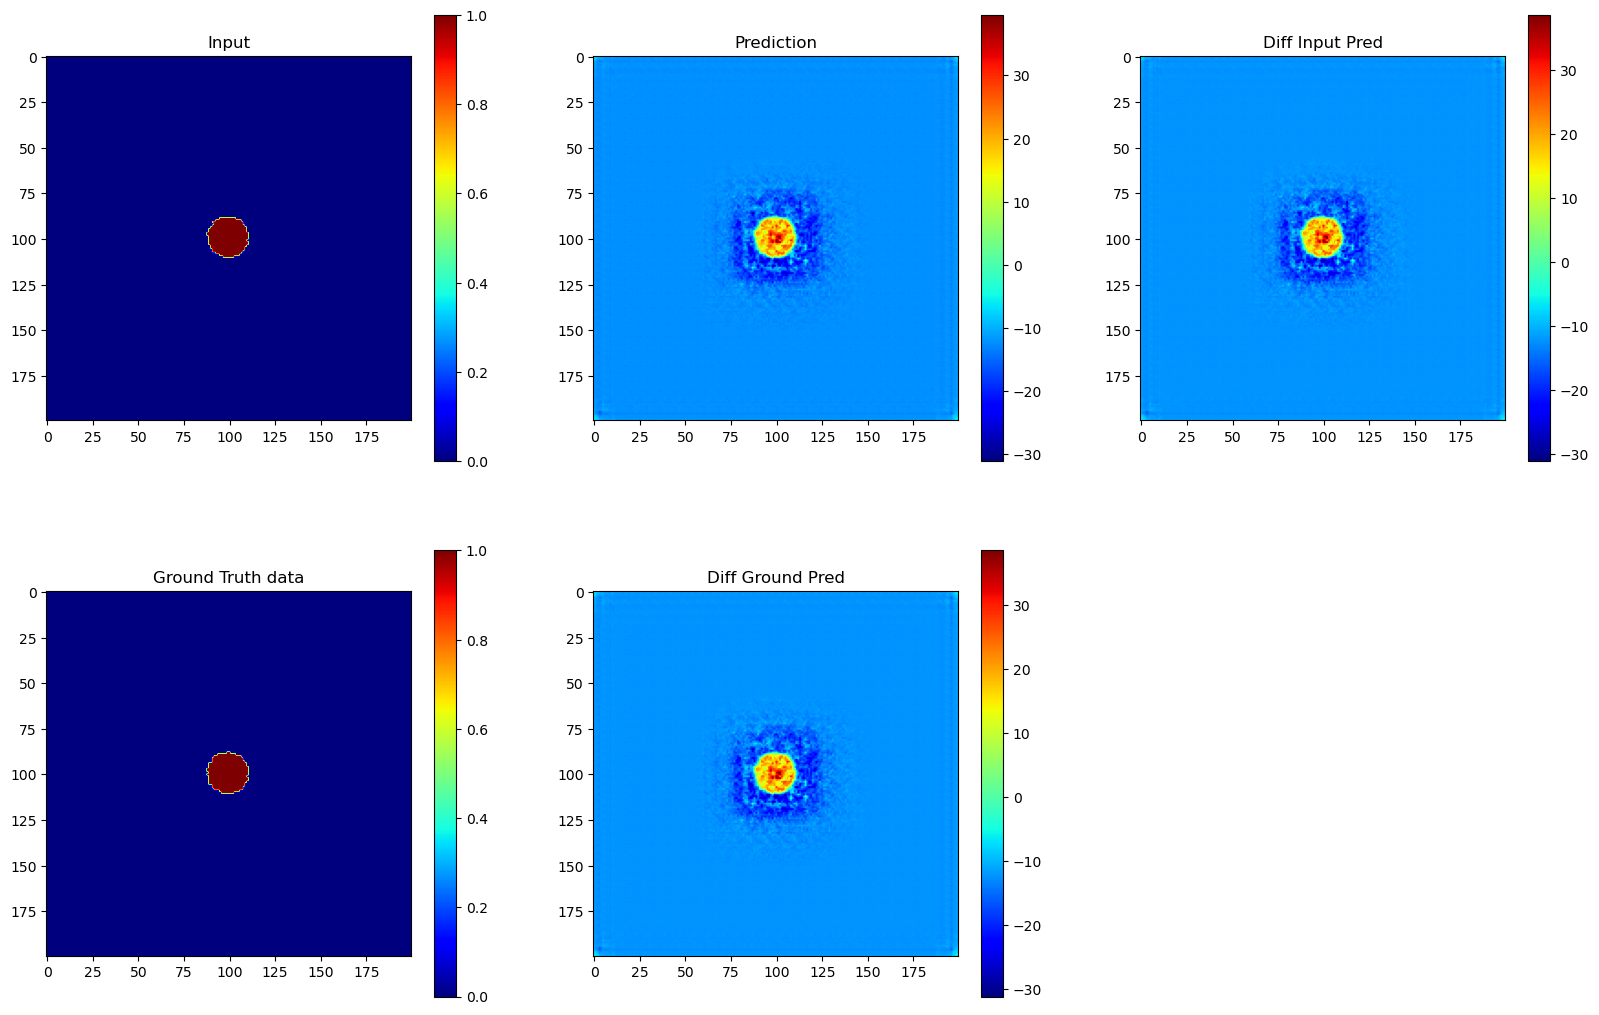

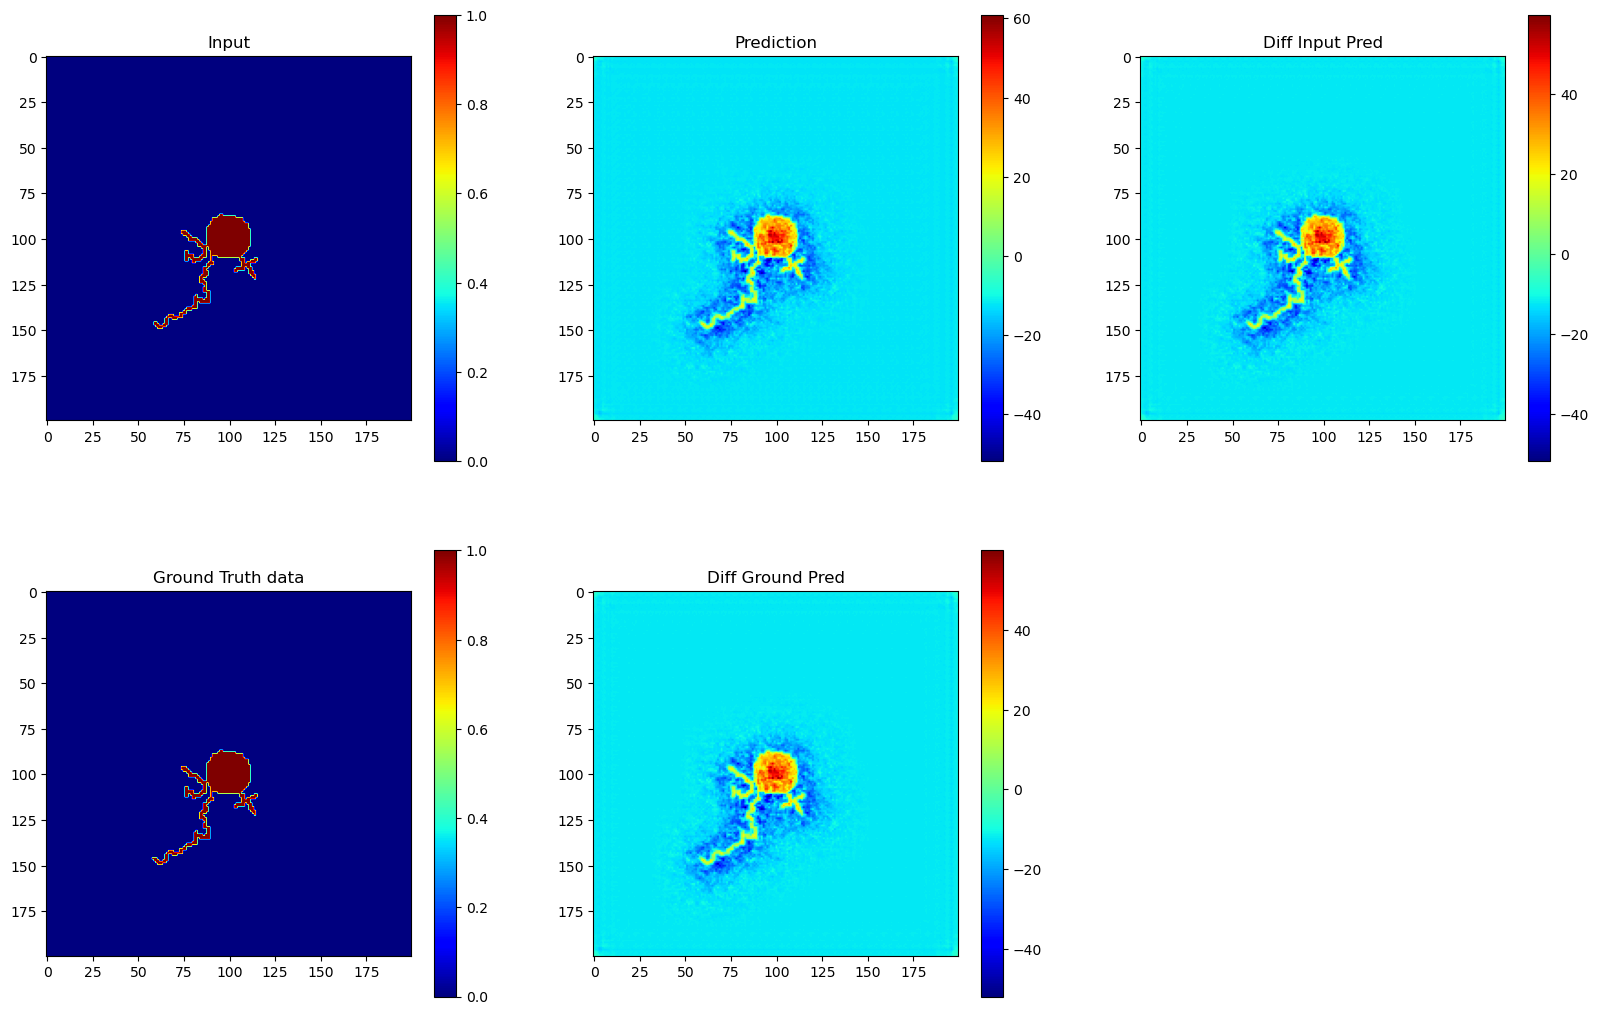

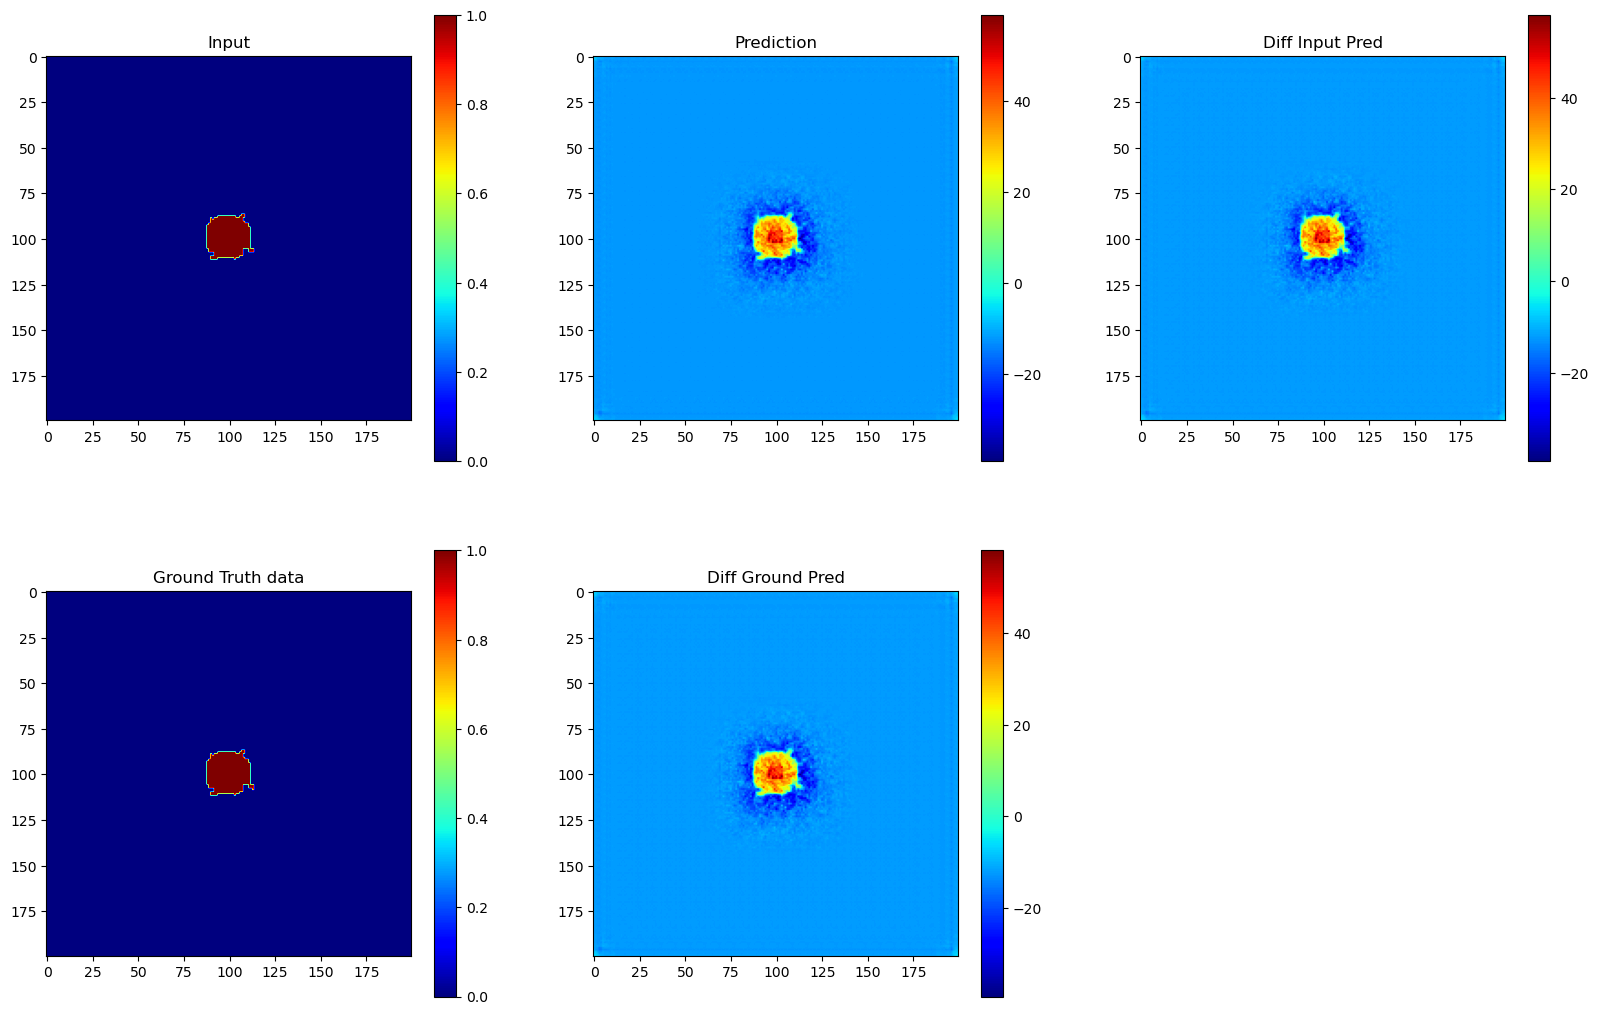

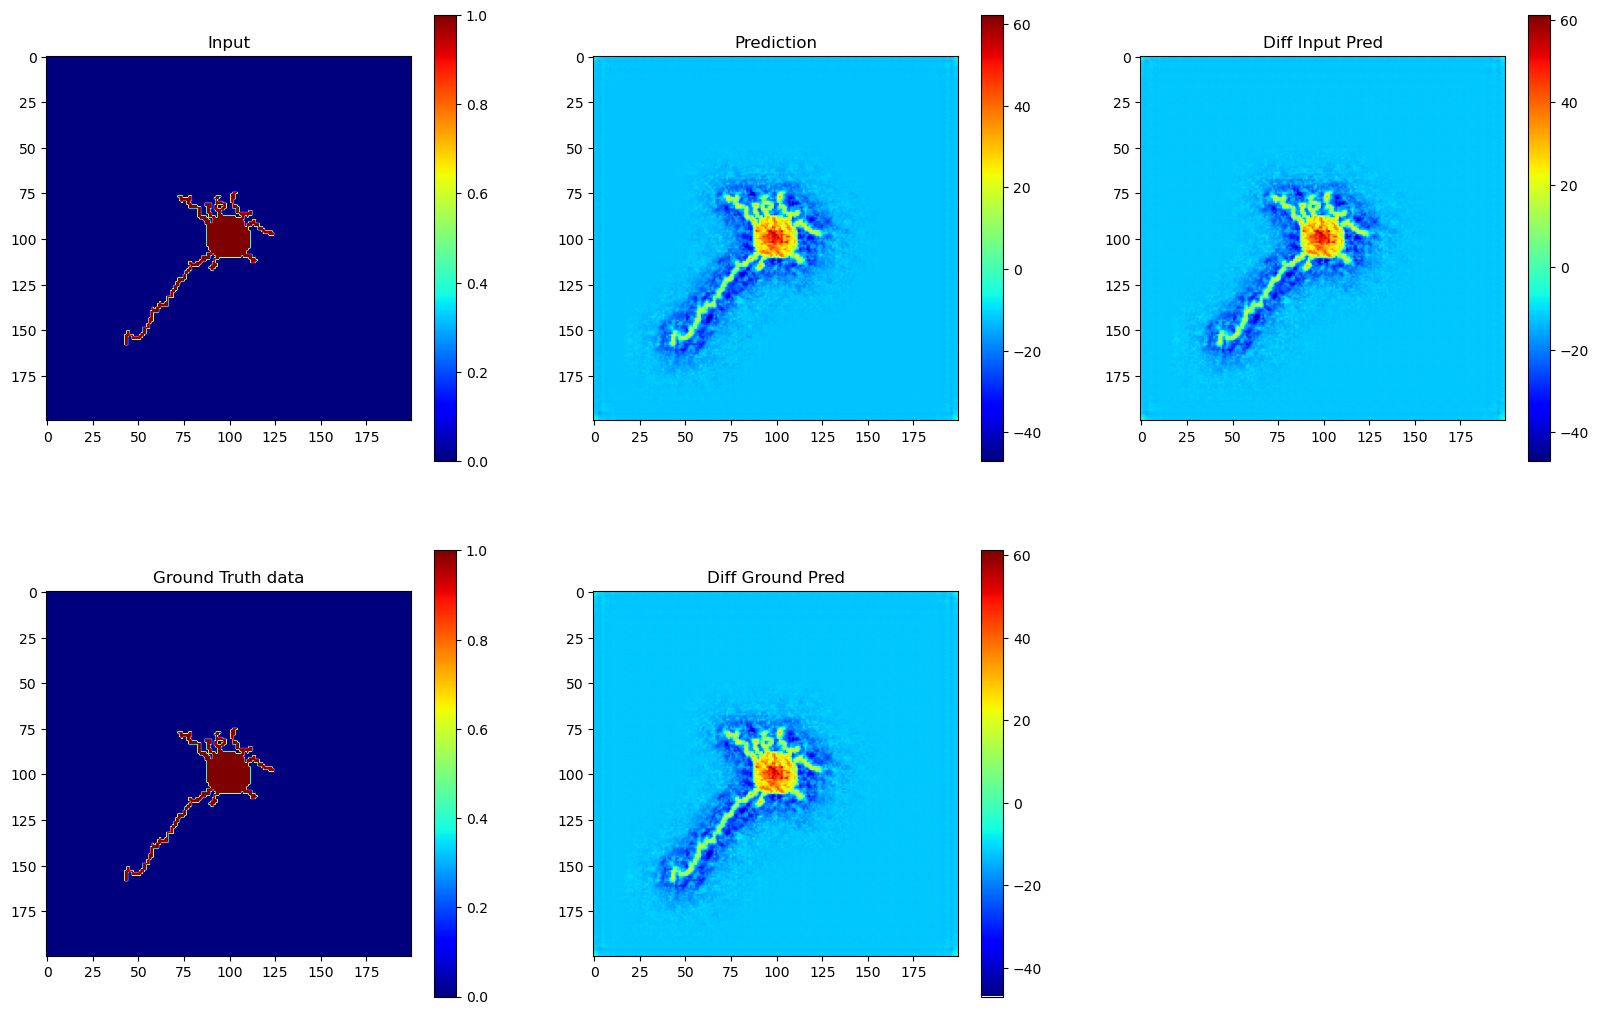

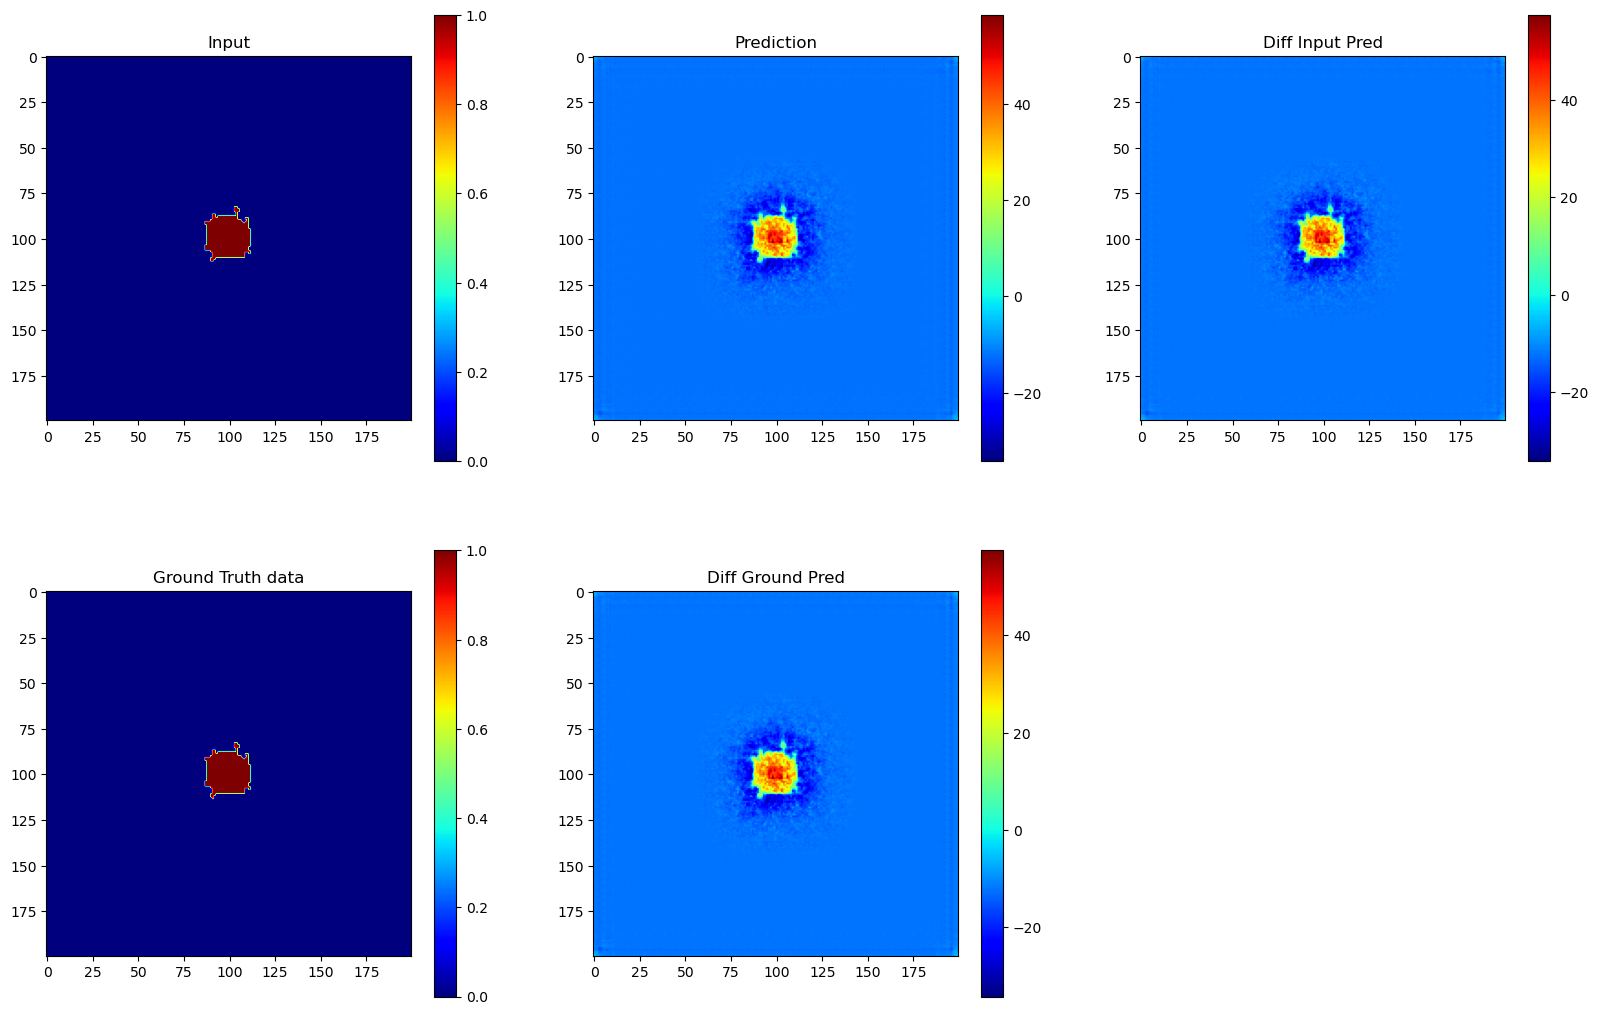

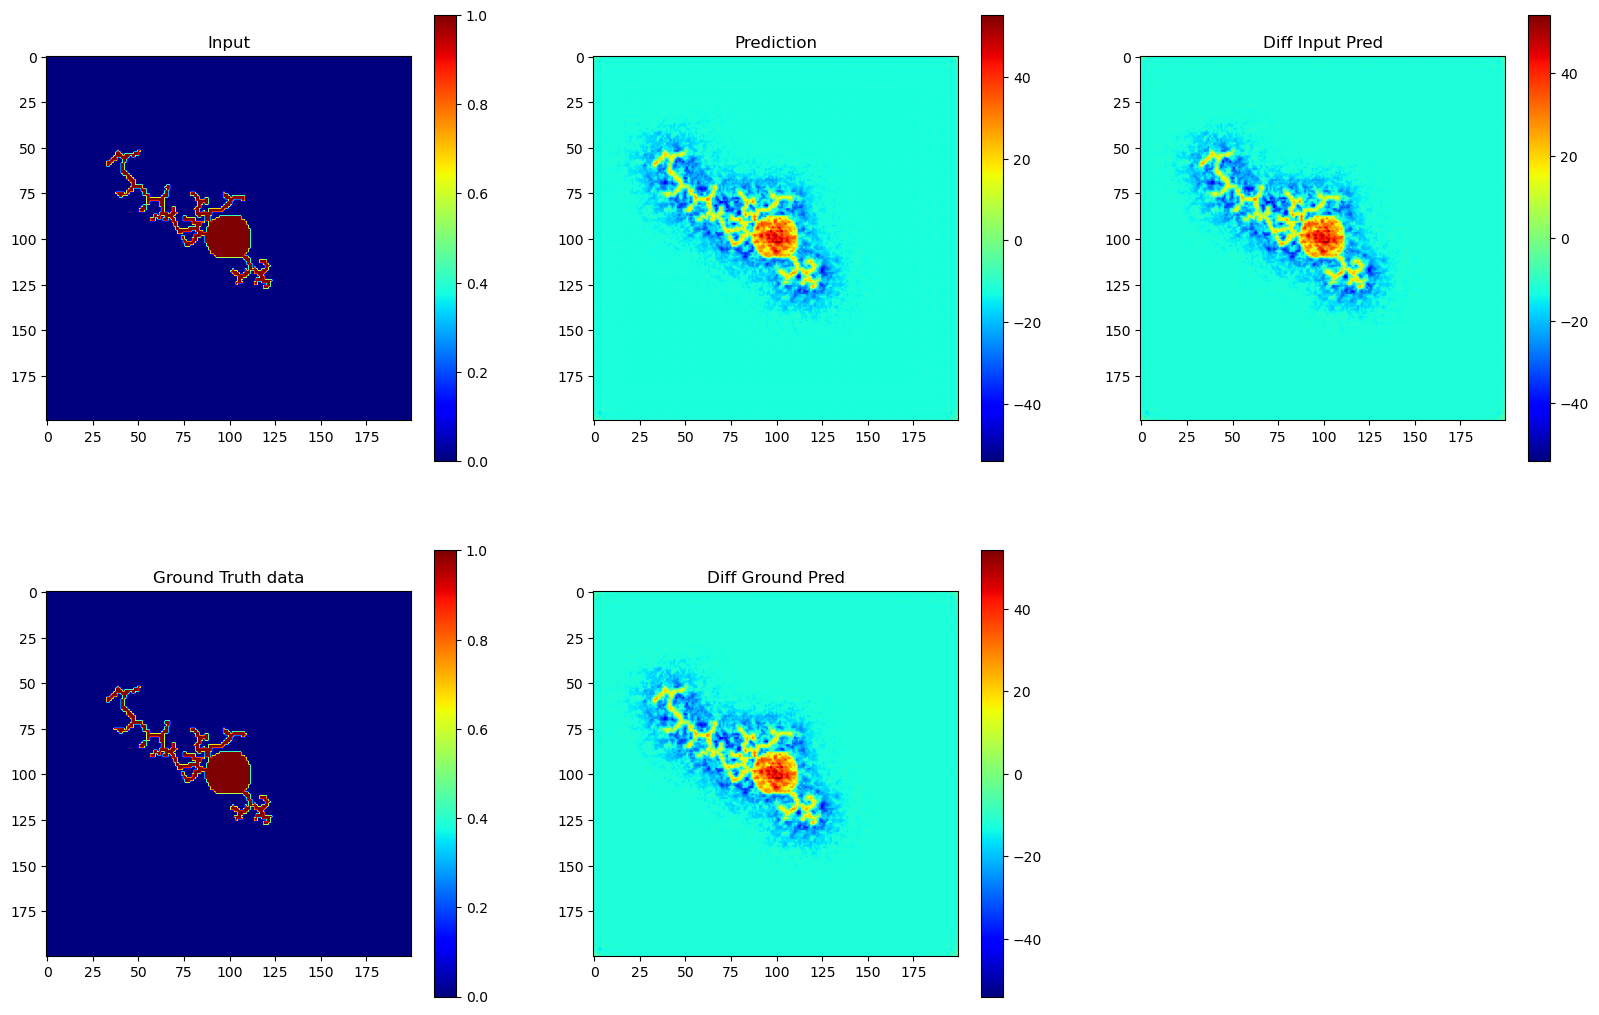

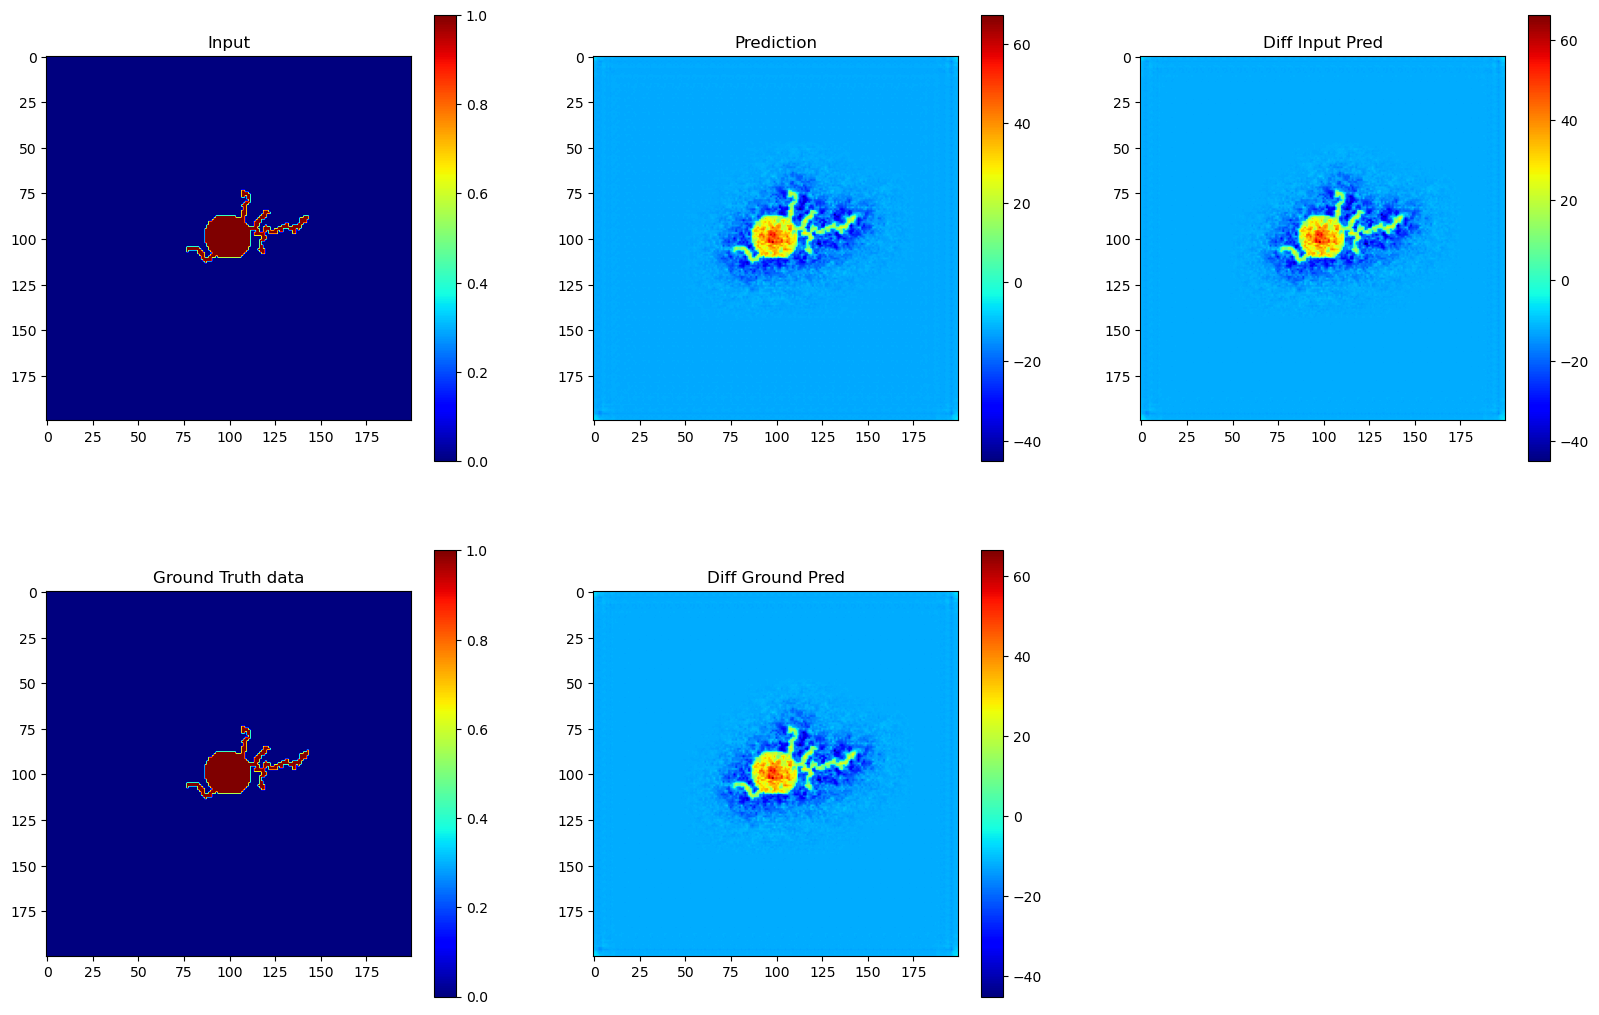

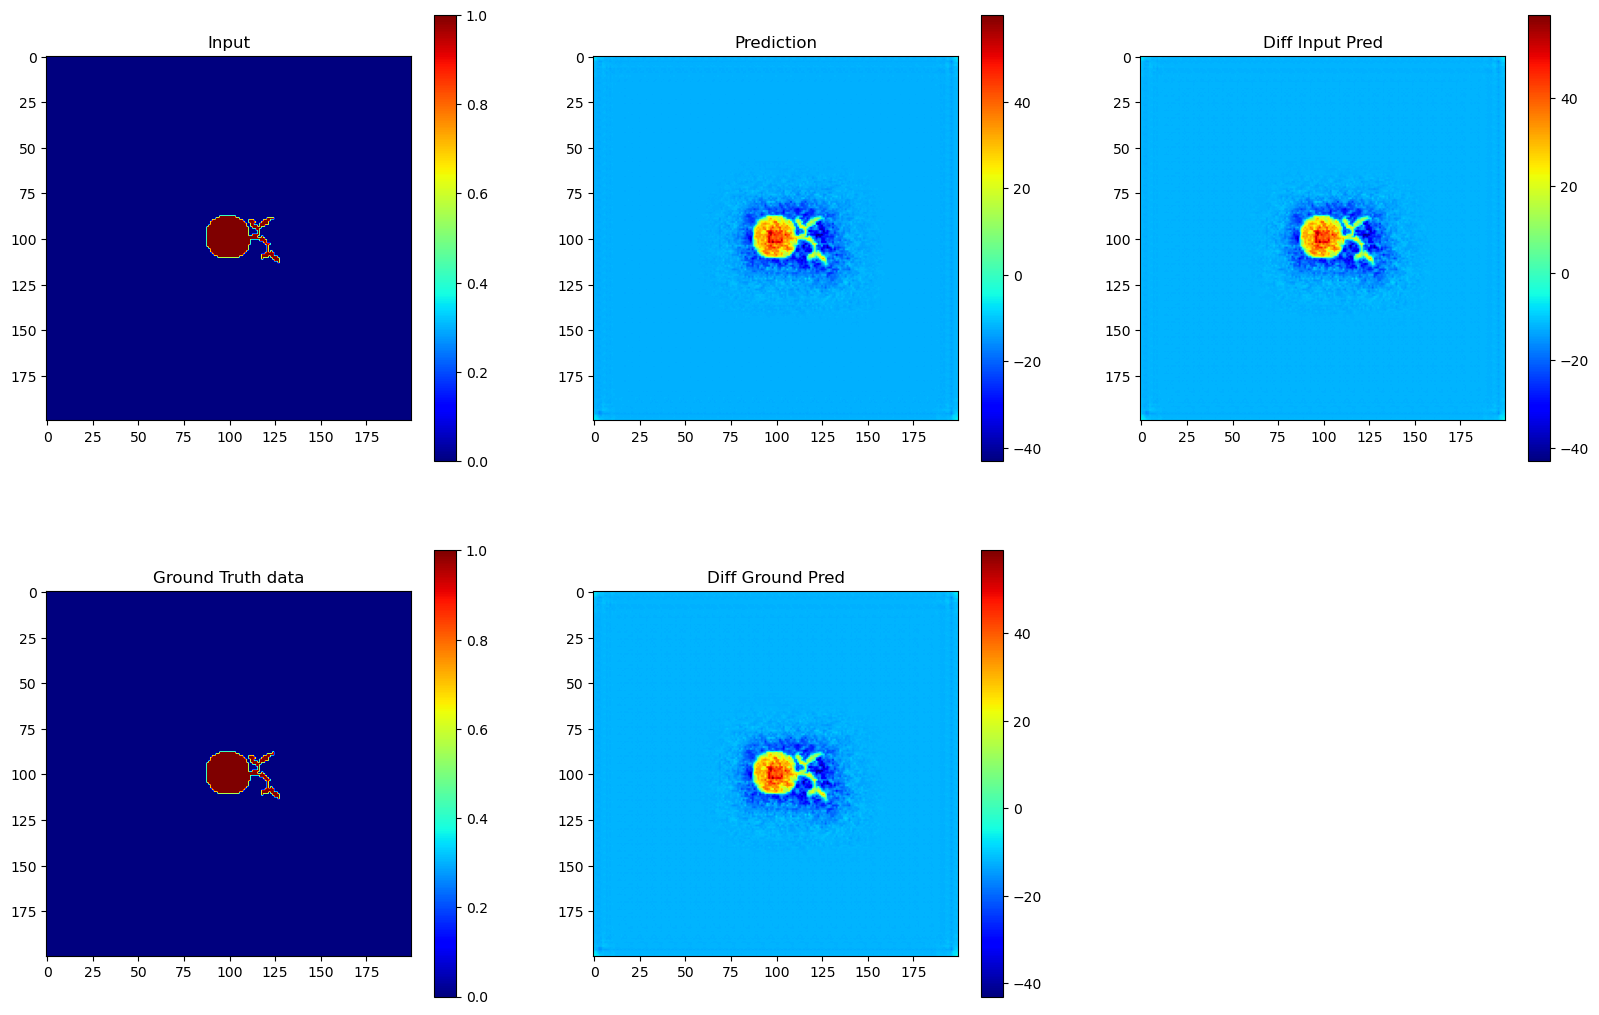

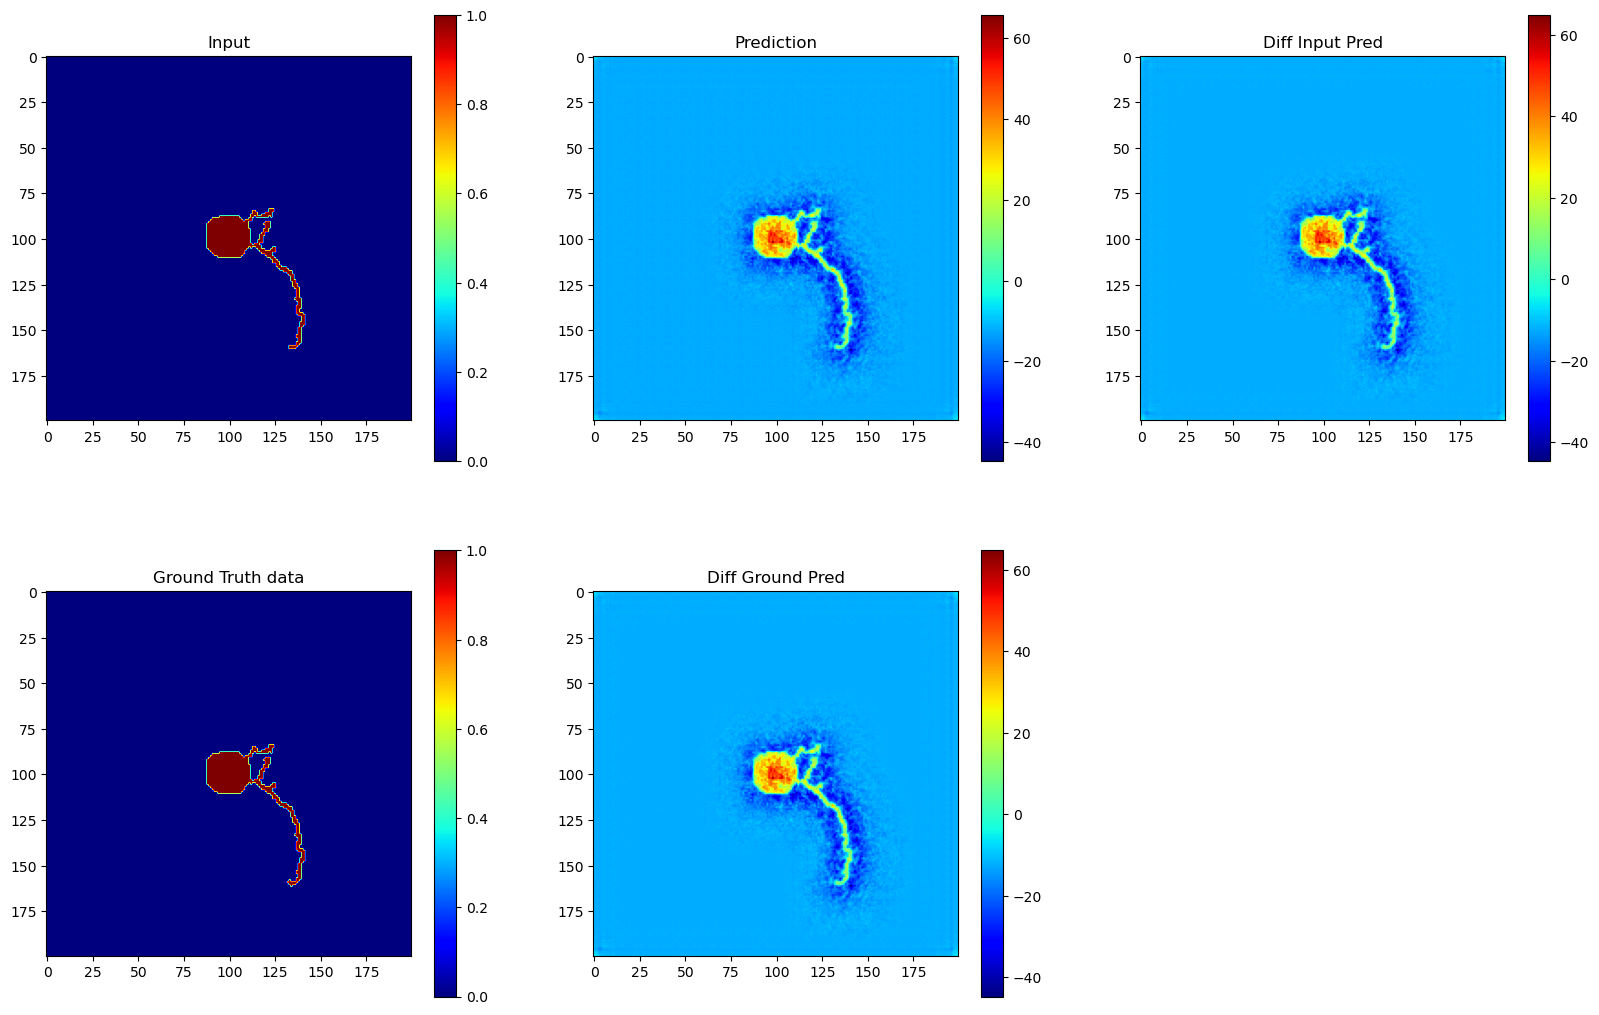

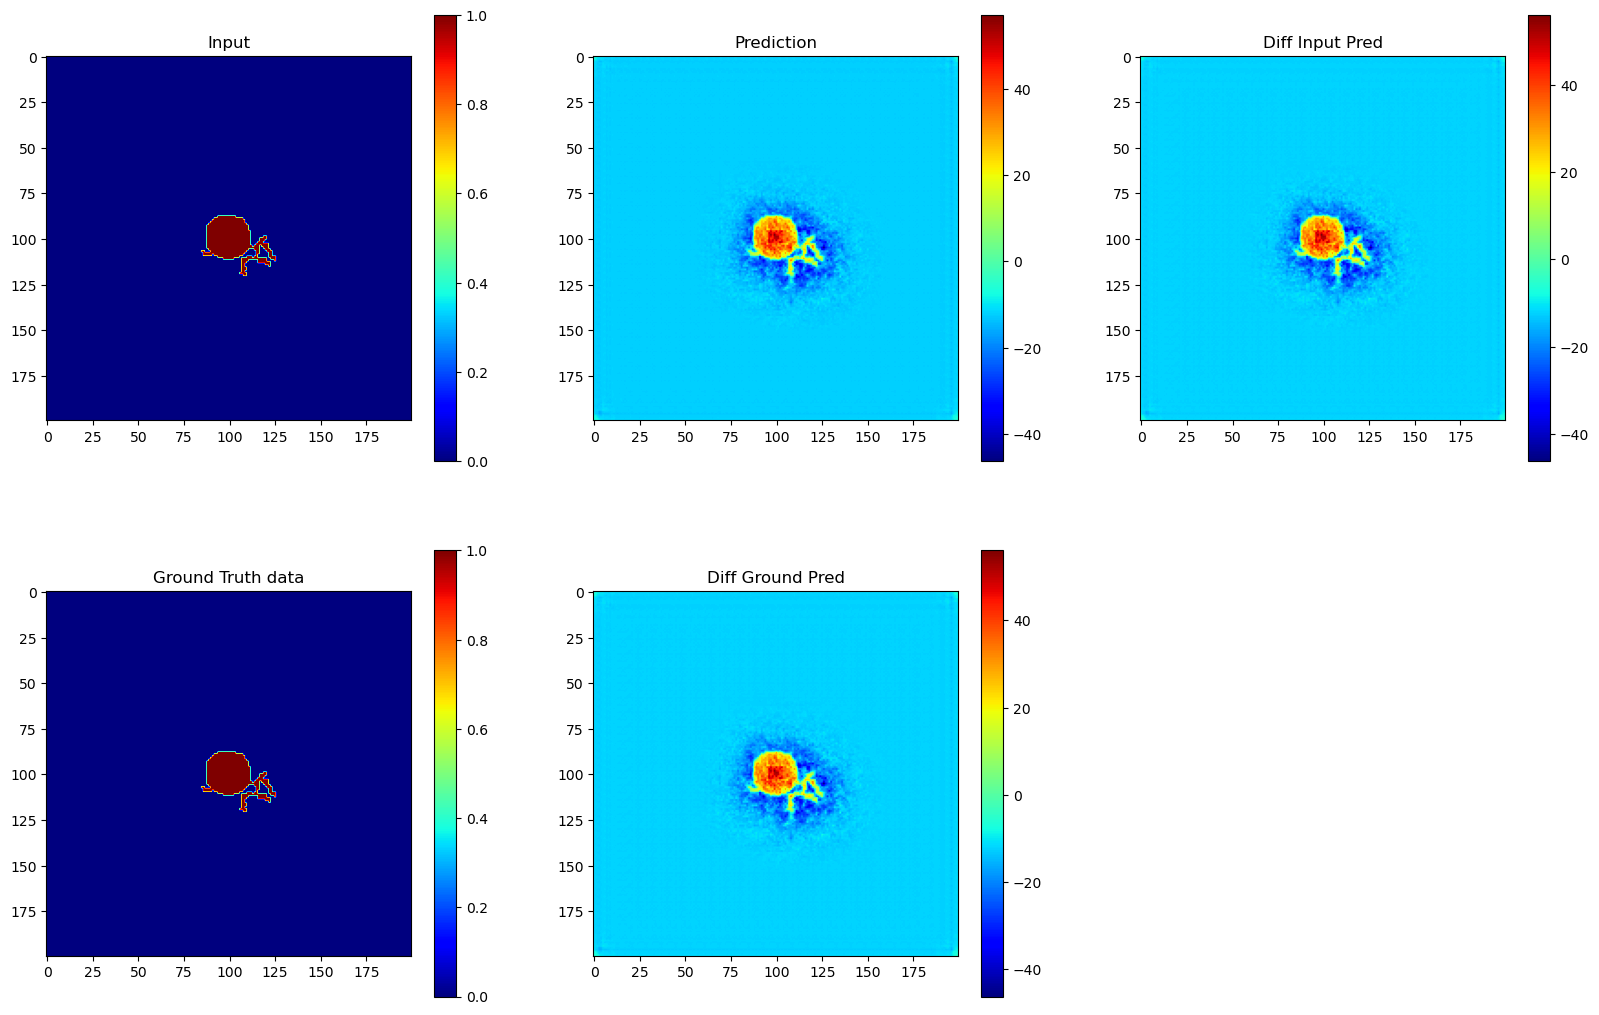

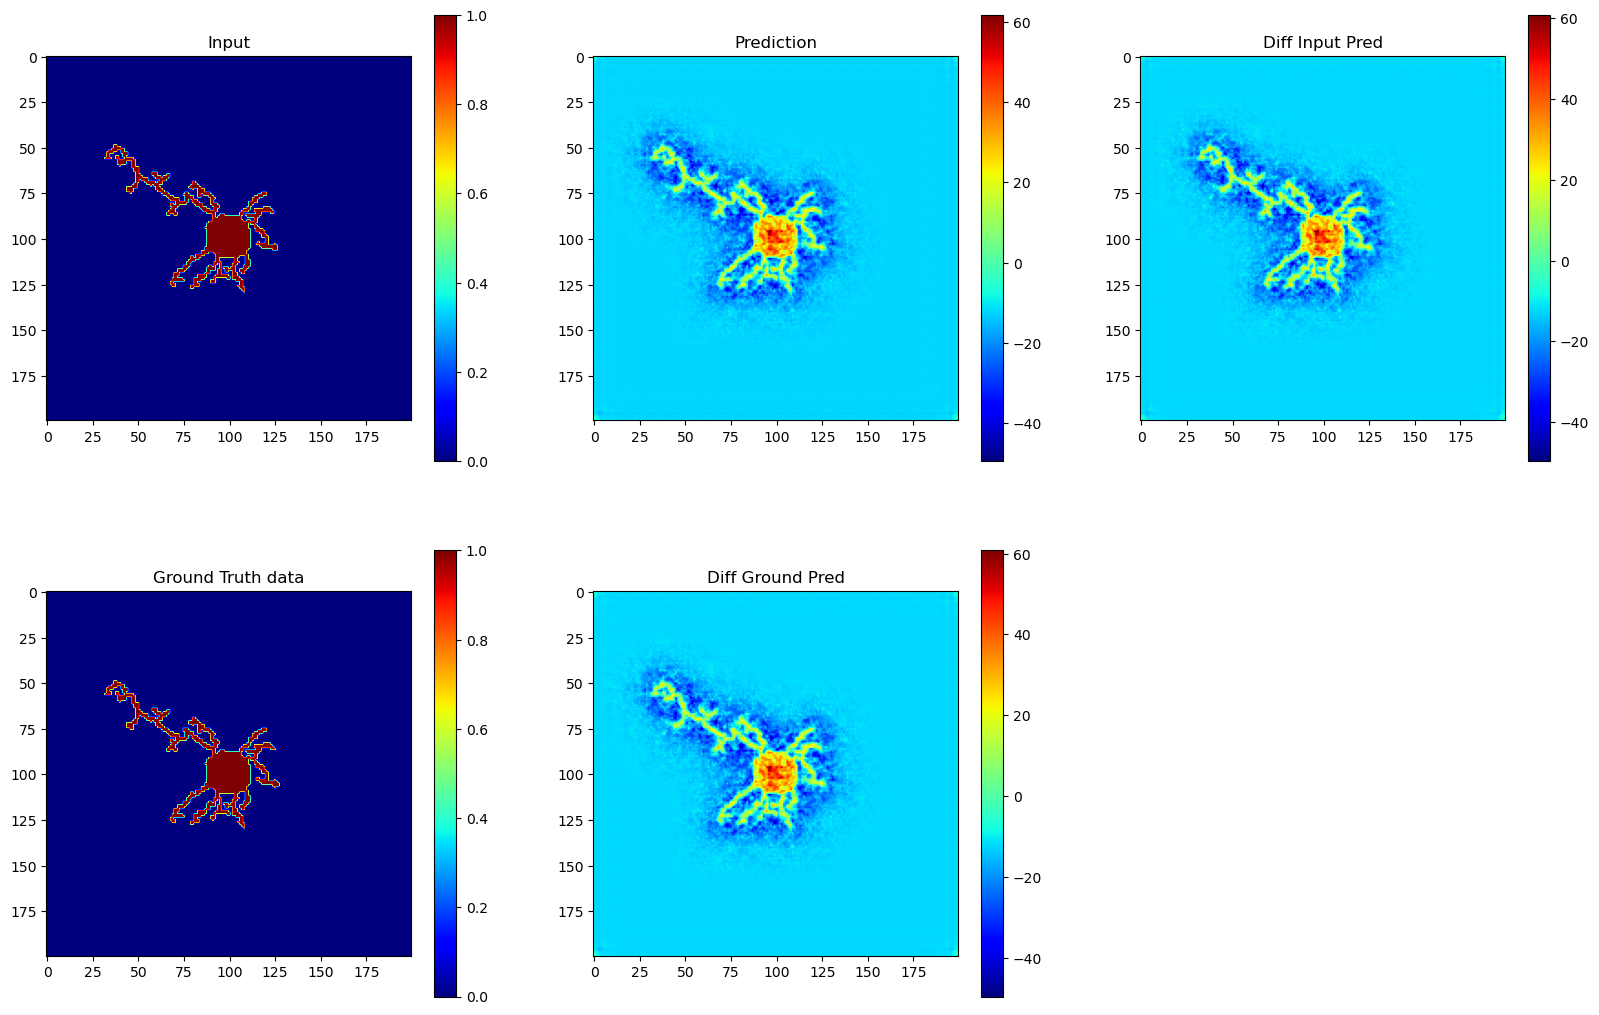

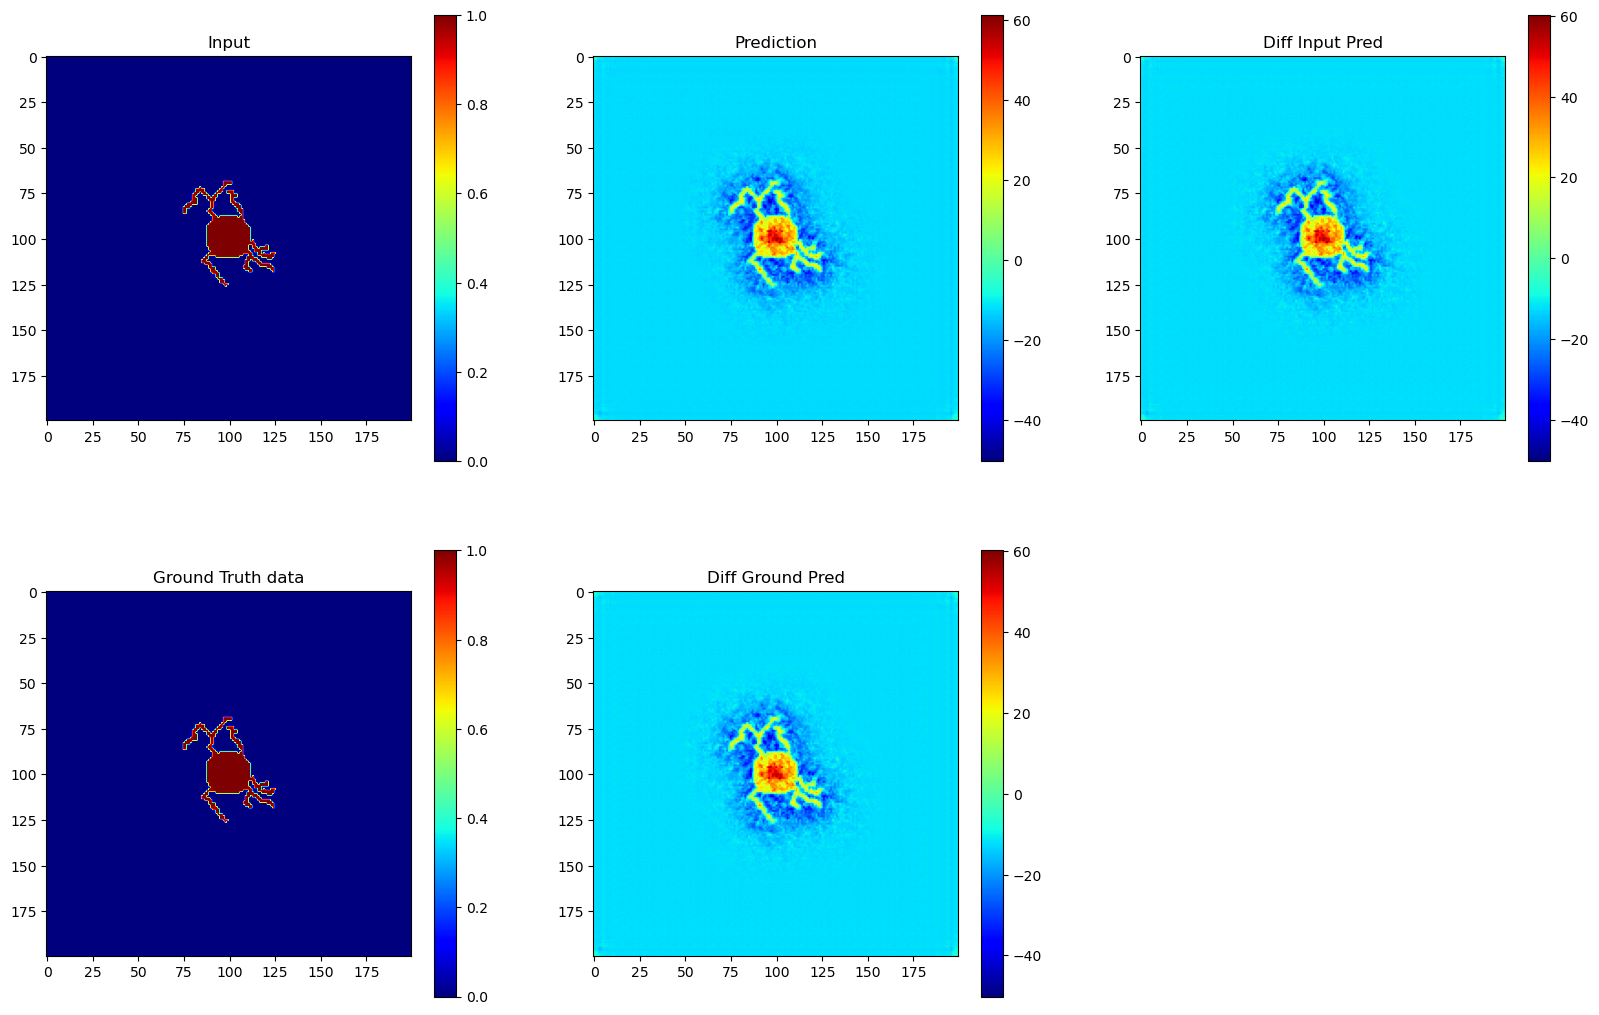

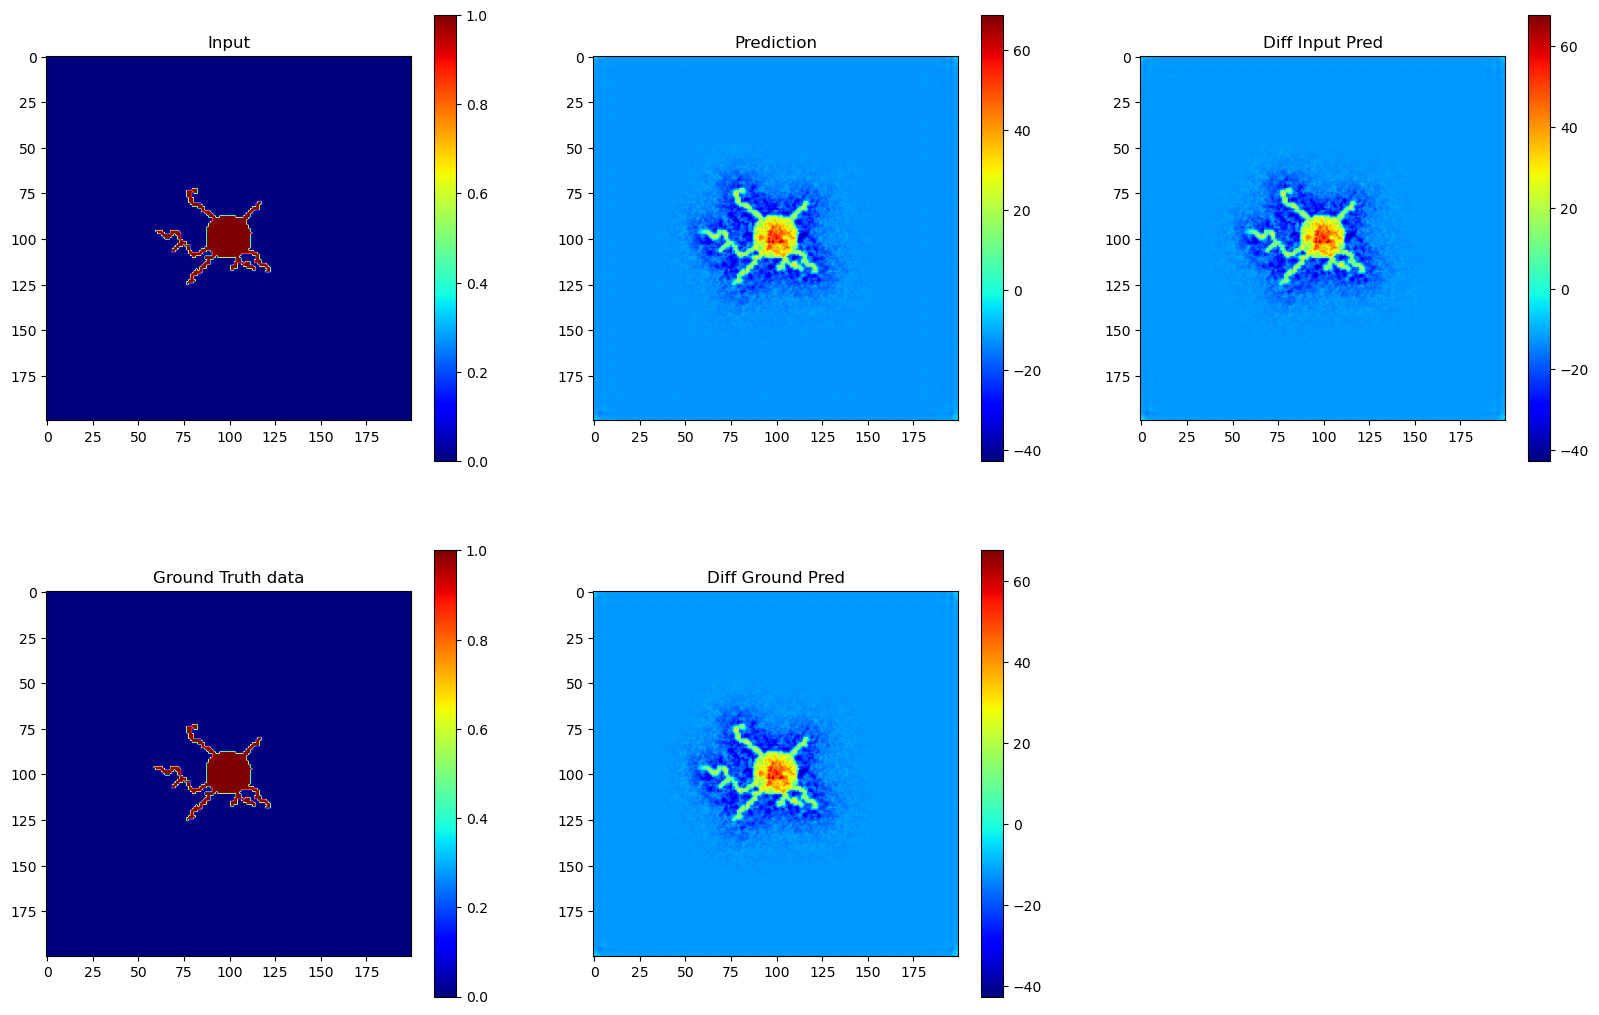

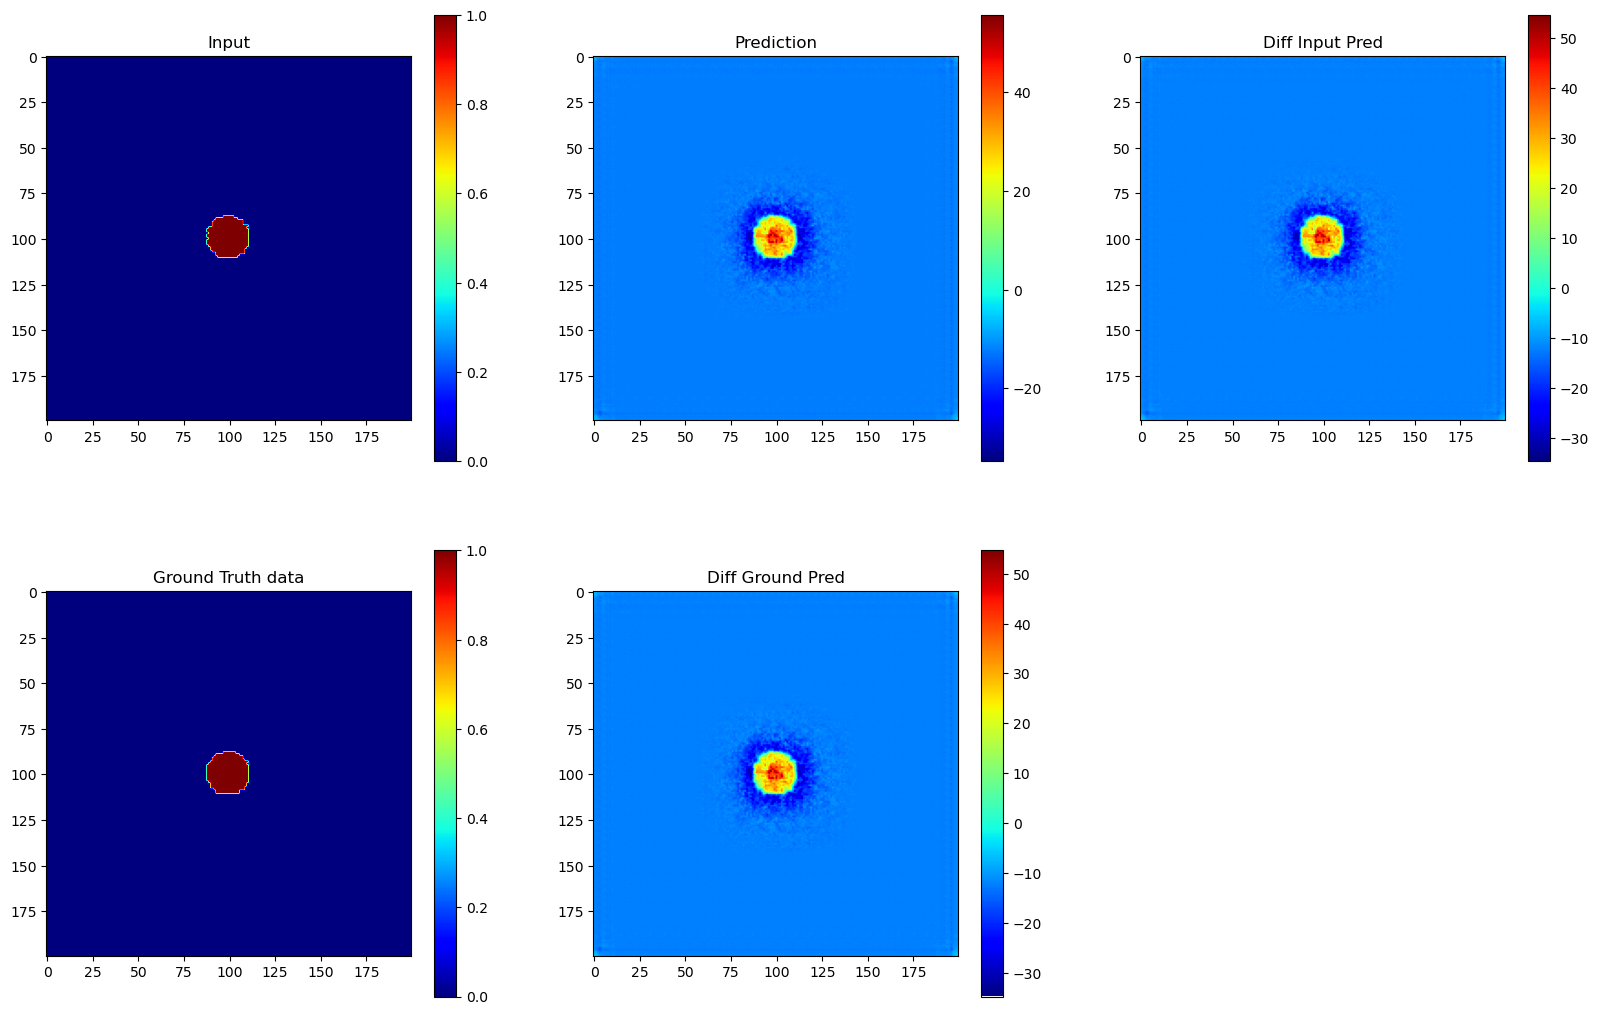

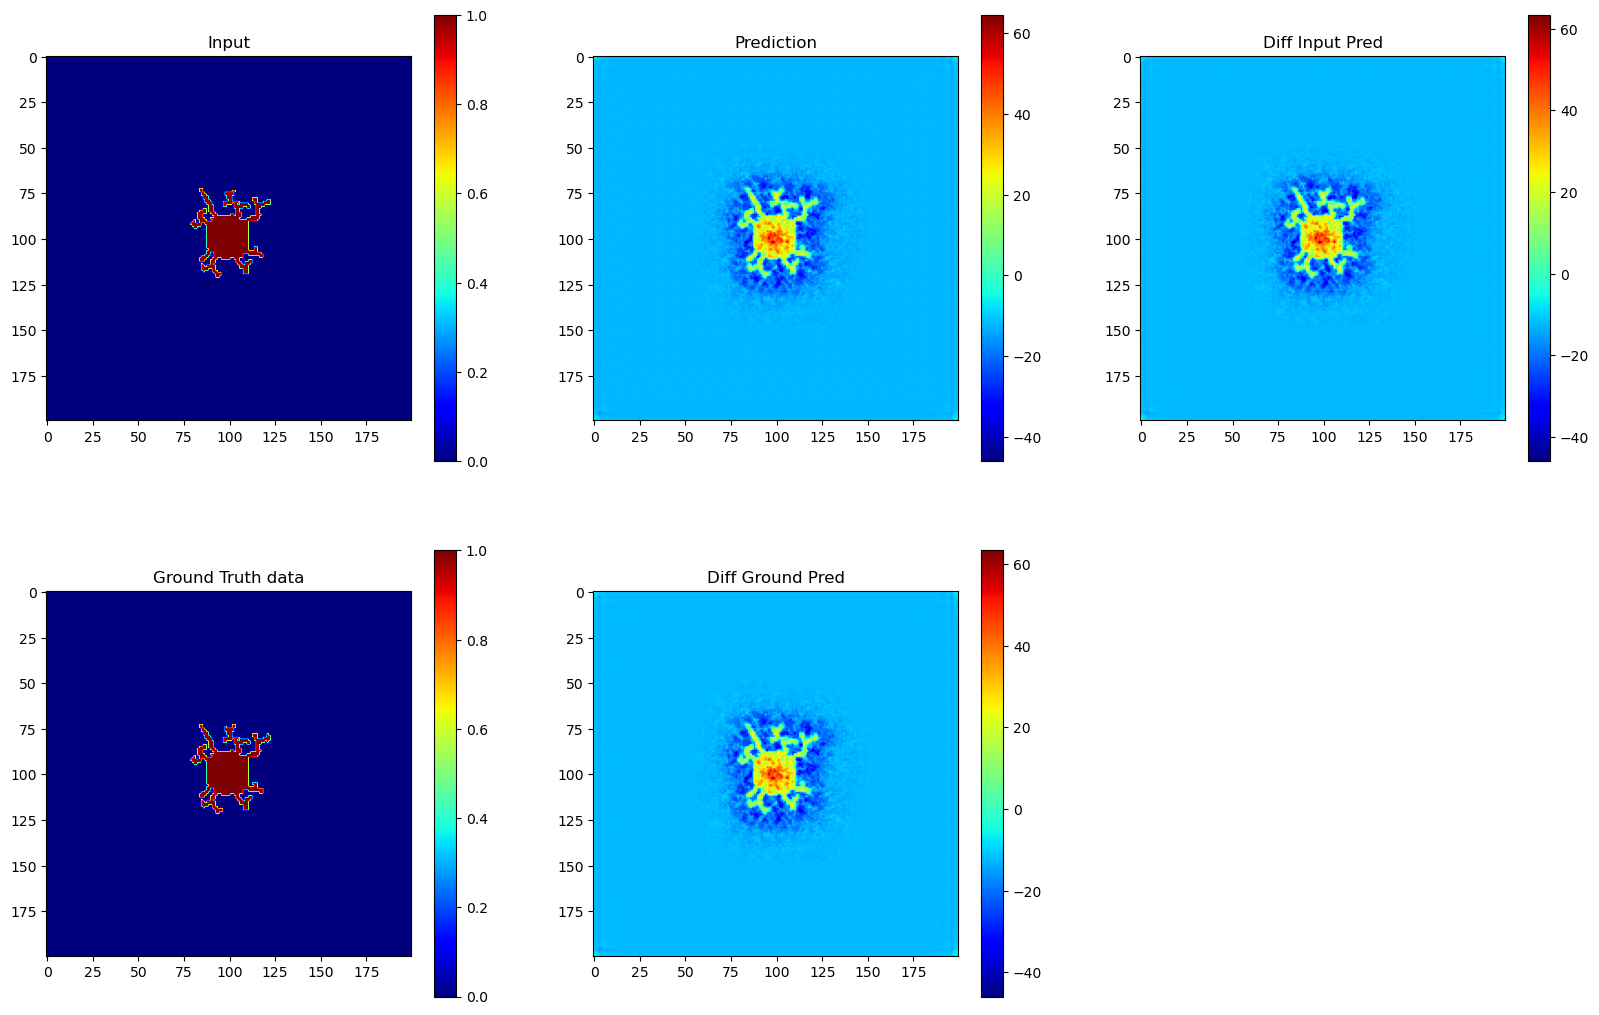

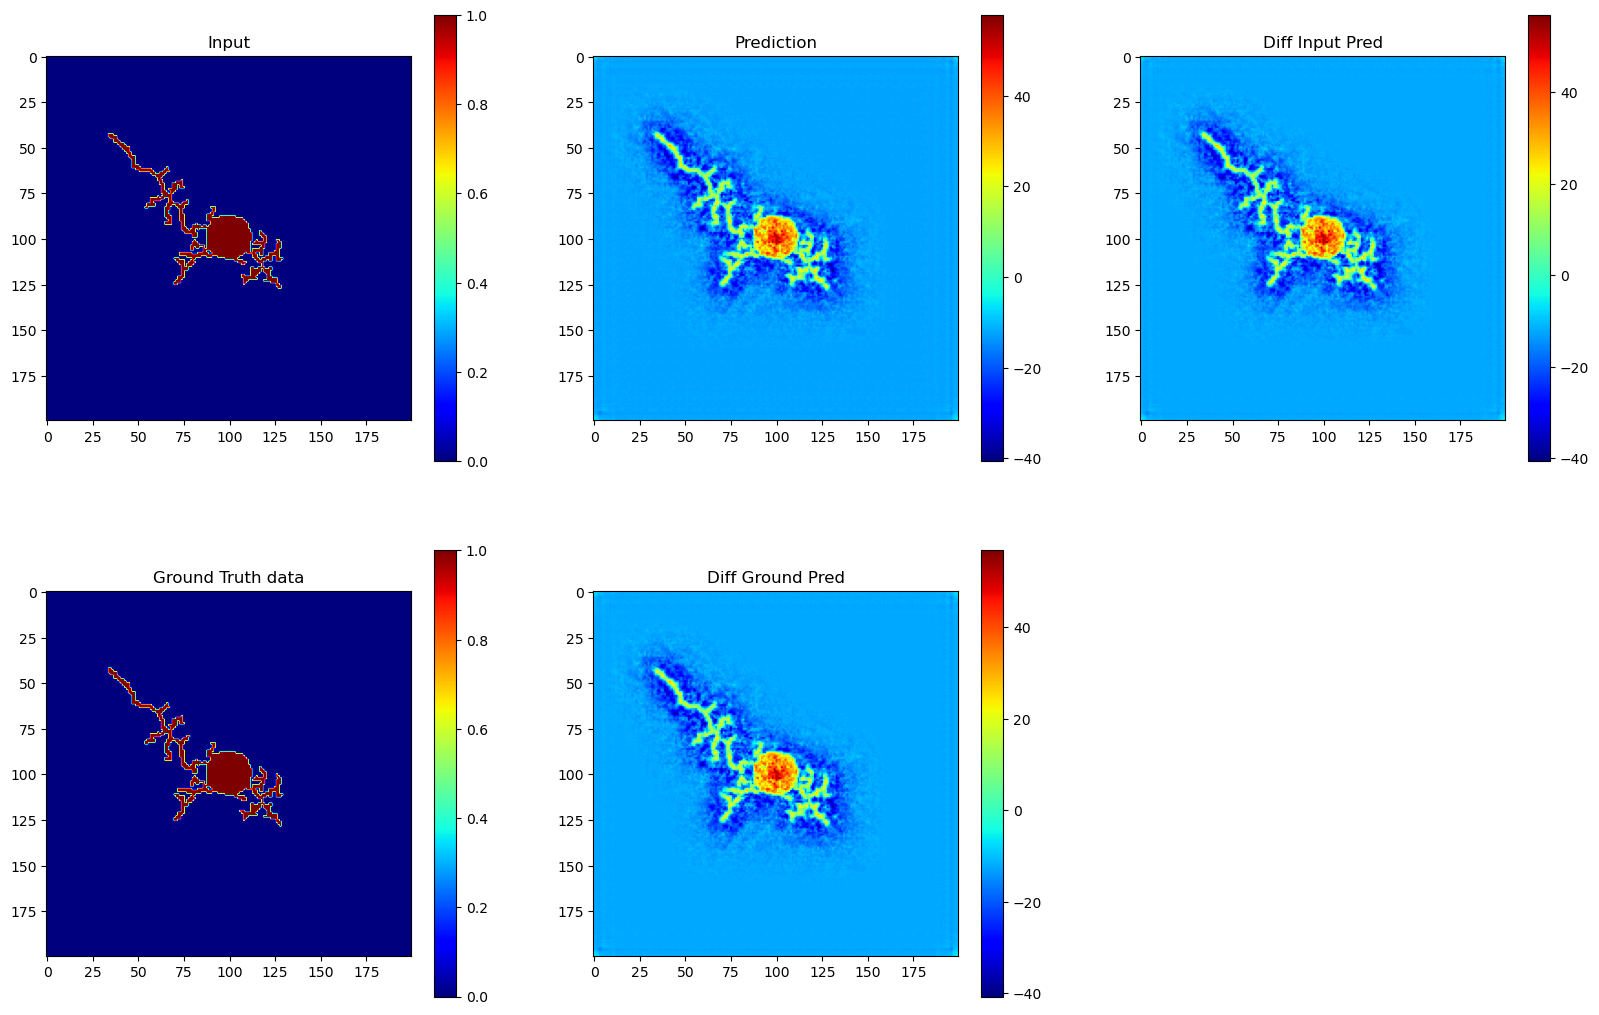

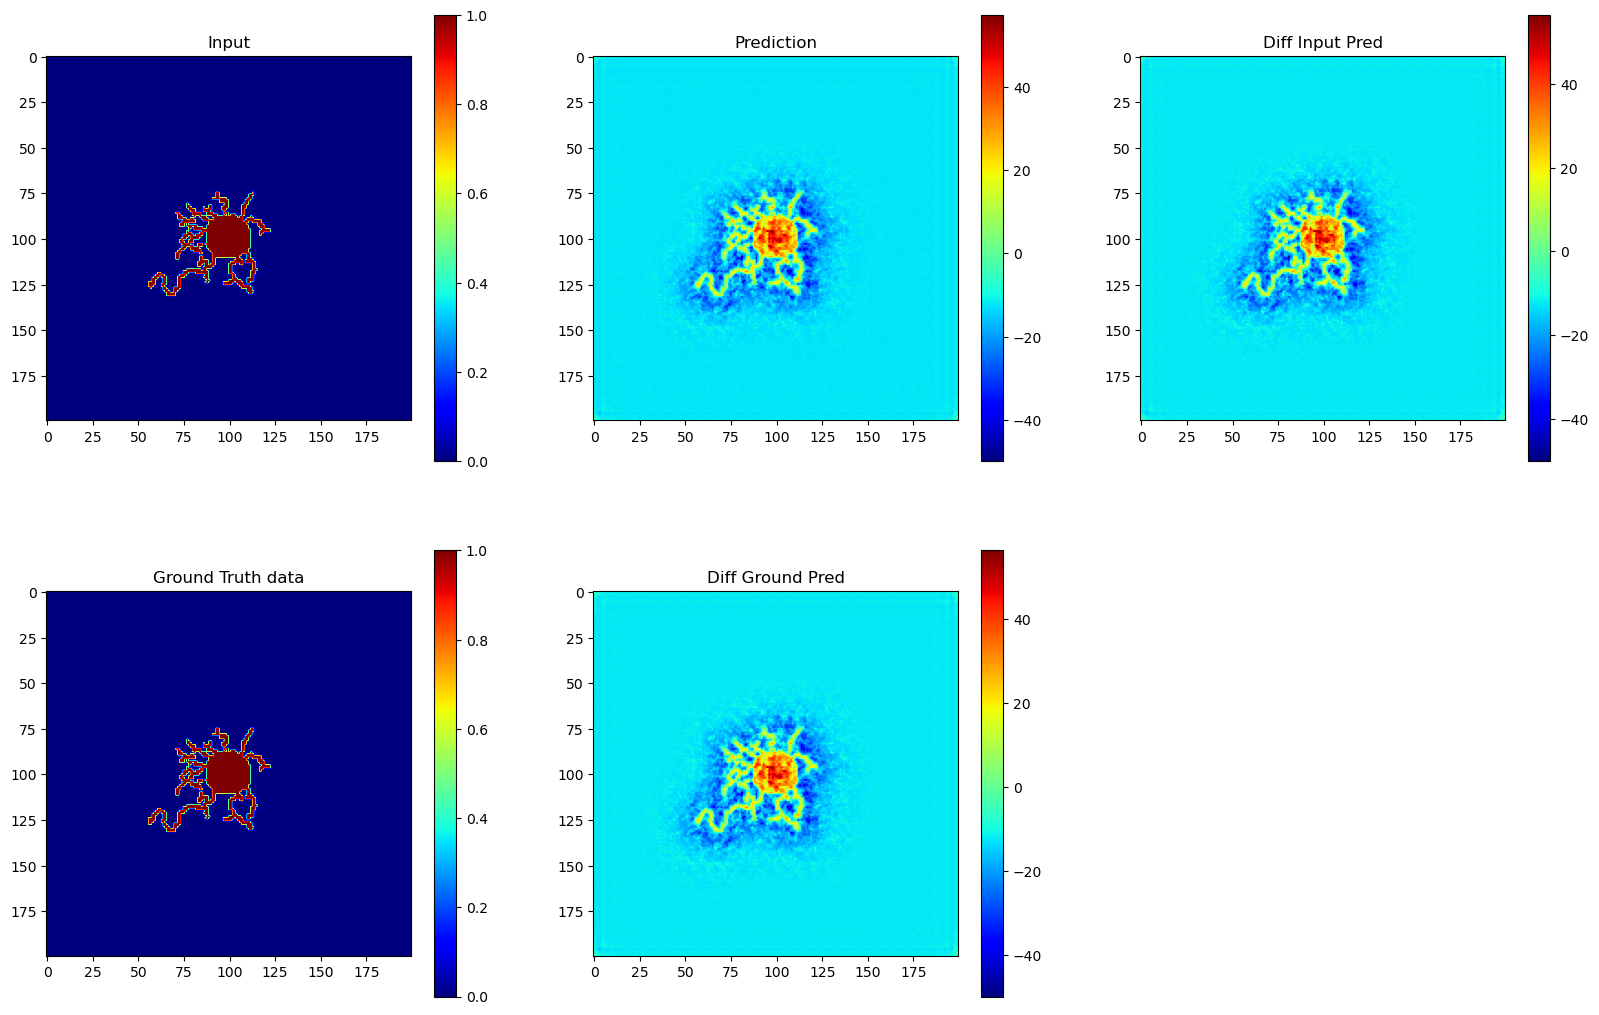

In [6]:
for i in range(1):
    input = input_L[i].cpu().numpy()
    target = target_L[i].cpu()
    prediction = prediction_L[i].cpu()
    for t in range(len(prediction)):
        plt.figure(figsize=(20,13), dpi=100)

        plt.subplot(2,3,1)
        plt.imshow(input[t,0,...],cmap = "jet")
        plt.title("Input")
        plt.colorbar()

        plt.subplot(2,3,2)
        plt.imshow(prediction[t][0],cmap = "jet")
        plt.title("Prediction")
        plt.colorbar()

        plt.subplot(2,3,3)
        plt.imshow(prediction[t][0]-input[t,0,...],cmap = "jet")
        plt.title("Diff Input Pred")
        plt.colorbar()

        plt.subplot(2,3,4)
        plt.imshow(target[t][0],cmap = "jet")
        plt.title("Ground Truth data")
        plt.colorbar()

        plt.subplot(2,3,5)
        plt.imshow(prediction[t][0]-target[t,0,...],cmap = "jet")
        plt.title("Diff Ground Pred")
        plt.colorbar()

    plt.show()

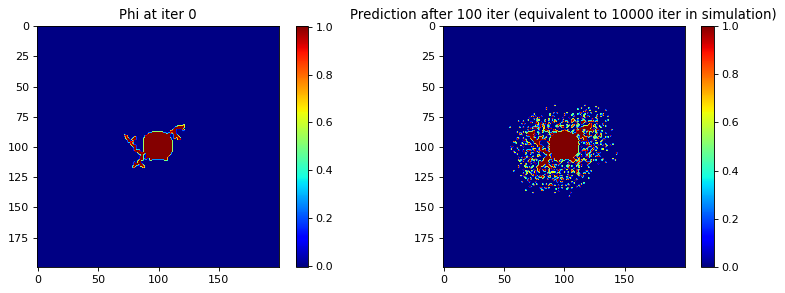

In [ ]:
import matplotlib.pyplot as plt
import h5py

h5 = h5py.File('./reformattedData/CNN_all_cases_200x200_per100_previousPhi_withTips_2layers_compressed.hdf5', mode='r')
ind = h5.get('input')[100,...]
oud = h5.get('output')

indind = torch.from_numpy(np.resize(ind,[1,2,200,200])).to(device, torch.float)

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(1,2,1)
plt.imshow(indind[0,0,:,:].cpu(),cmap='jet')
plt.title('Phi at iter 0')
plt.colorbar()

cutoff = 0.02
for i in range(100):
    prediction = model(indind)
    pred = prediction.cpu().detach().numpy()

    pred[pred>cutoff]=1
    pred[pred<cutoff]=0

    input_temp = np.zeros([2,200,200])
    input_temp[0,...] = pred
    input_temp[1,...] = ind[1,...]
    input = torch.from_numpy(np.resize(input_temp,[1,4,200,200])).to(device, torch.float)

plt.subplot(1,2,2)
plt.imshow(pred[0,0,...],cmap='jet')
plt.title('Prediction after 100 iter (equivalent to 10000 iter in simulation)')
plt.colorbar()

# plt.subplot(1,3,3)
# plt.imshow(pred[0,0,...]-indind[0,0,:,:].cpu().detach().numpy(),cmap='jet')
# plt.title('Difference ')
# plt.colorbar()